# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-import-and-preprocessing" data-toc-modified-id="Data-import-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and preprocessing</a></div><div class="lev1 toc-item"><a href="#Preparing-Test-Data" data-toc-modified-id="Preparing-Test-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Test Data</a></div><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Fitting-GP-on-training-data" data-toc-modified-id="Fitting-GP-on-training-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting GP on training data</a></div><div class="lev2 toc-item"><a href="#Predicting-at-the-test-location" data-toc-modified-id="Predicting-at-the-test-location-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predicting at the test location</a></div><div class="lev1 toc-item"><a href="#Specifying-STAN-model" data-toc-modified-id="Specifying-STAN-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Specifying STAN model</a></div><div class="lev1 toc-item"><a href="#Running-STAN" data-toc-modified-id="Running-STAN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Running STAN</a></div><div class="lev1 toc-item"><a href="#Plotting" data-toc-modified-id="Plotting-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting</a></div><div class="lev1 toc-item"><a href="#Observations" data-toc-modified-id="Observations-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Observations</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
$$

Build the pipeline to get the data into STAN.

In [1]:
using Stan

using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [3]:
include("src/preprocessing.jl")
include("src/variogram.jl")

cov (generic function with 63 methods)

In [4]:
isdList=read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

4×13 DataFrames.DataFrame
│ Row │ USAF   │ WBAN  │ NAME                             │ CTRY │ STATE │
├─────┼────────┼───────┼──────────────────────────────────┼──────┼───────┤
│ 1   │ 725450 │ 14990 │ THE EASTERN IOWA AIRPORT         │ US   │ IA    │
│ 2   │ 725460 │ 14933 │ DES MOINES INTERNATIONAL AIRPORT │ US   │ IA    │
│ 3   │ 725480 │ 94910 │ WATERLOO MUNICIPAL AIRPORT       │ US   │ IA    │
│ 4   │ 725485 │ 14940 │ MASON CITY MUNICIPAL ARPT        │ US   │ IA    │

│ Row │ ICAO │ LAT    │ LON     │ ELEV  │ BEGIN │ END  │ X_PRJ     │ Y_PRJ     │
├─────┼──────┼────────┼─────────┼───────┼───────┼──────┼───────────┼───────────┤
│ 1   │ KCID │ 41.883 │ -91.717 │ 264.6 │ 1973  │ 2015 │ 1.64799e6 │ 1.0441e6  │
│ 2   │ KDSM │ 41.534 │ -93.653 │ 291.7 │ 1973  │ 2015 │ 1.48723e6 │ 1.00379e6 │
│ 3   │ KALO │ 42.554 │ -92.401 │ 264.6 │ 1960  │ 2015 │ 1.59025e6 │ 1.11766e6 │
│ 4   │ KMCW │ 43.154 │ -93.327 │ 373.4 │ 1973  │ 2015 │ 1.51407e6 │ 1.18374e6 │

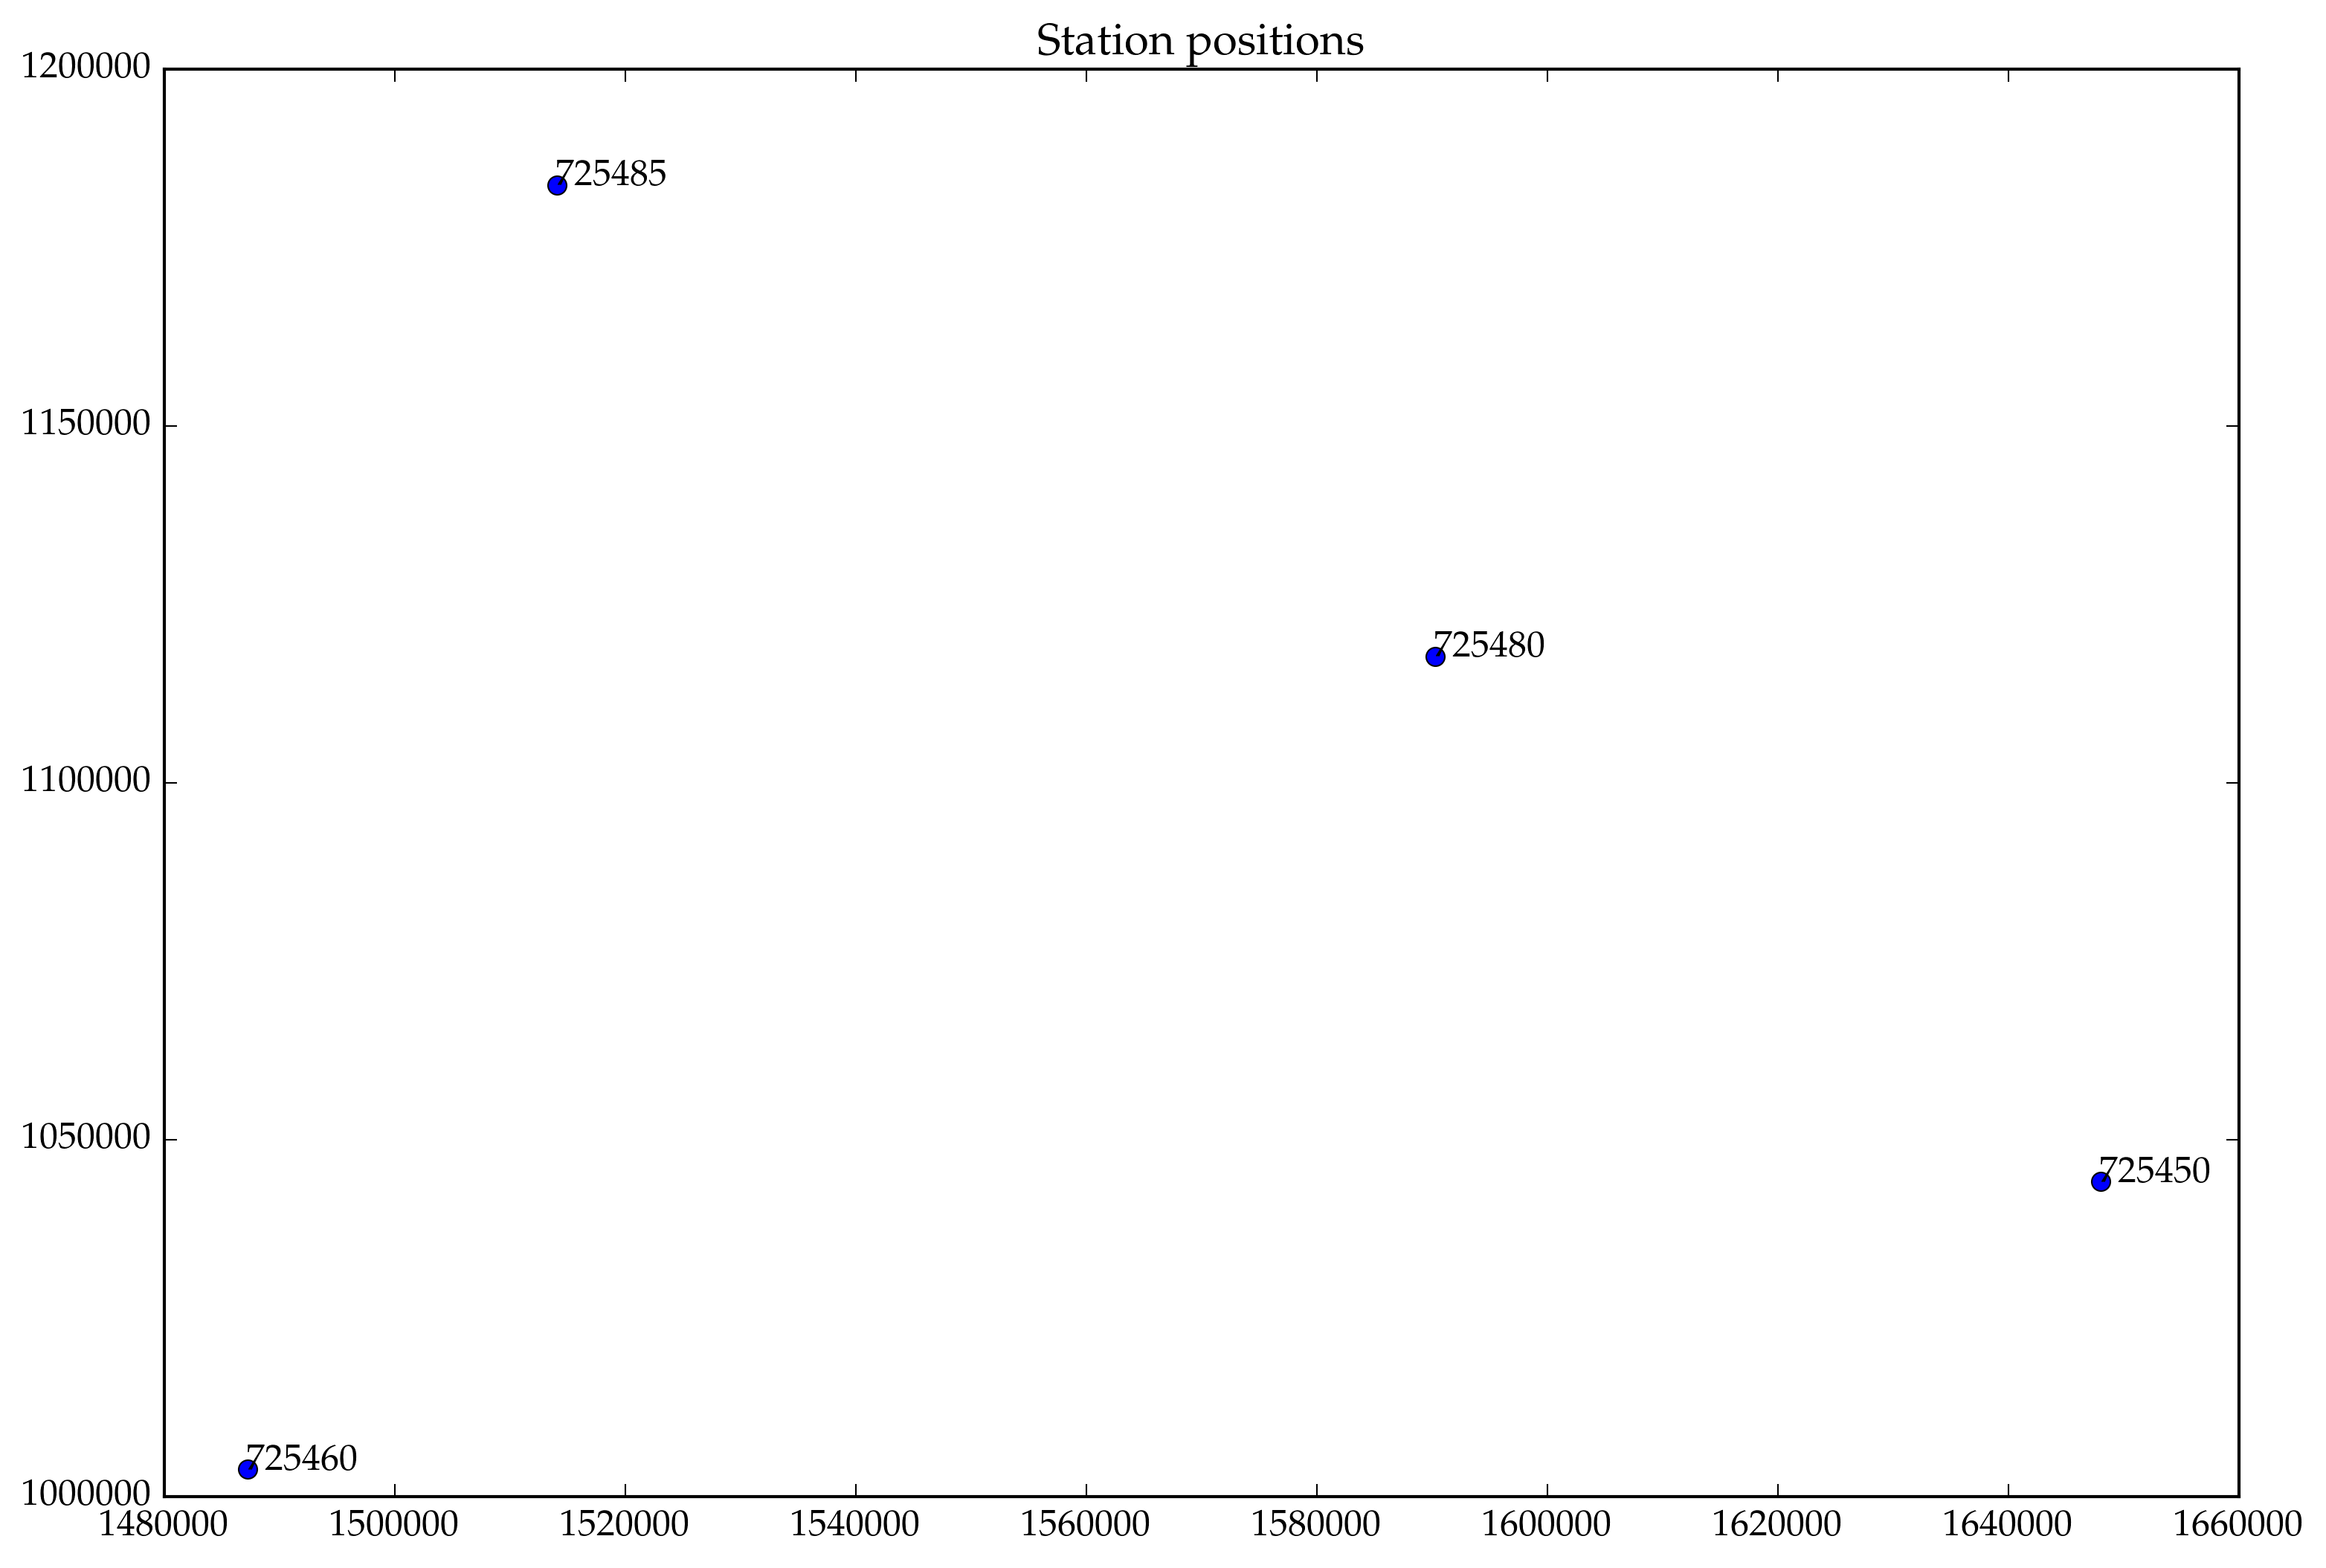

In [5]:
plt.plot(isdSubset[:X_PRJ].values, isdSubset[:Y_PRJ].values, "o")
for r in eachrow(isdSubset)
    plt.text(get(r[:X_PRJ]), get(r[:Y_PRJ]), get(r[:USAF]))
end
plt.title("Station positions")
;

In [6]:
hourly_cat=read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)

(35169,12695)

# Preparing Test Data

In [7]:
hr_measure = 17.0 # number between 0 and 24
ts = hourly_test[:ts_hours].values

day_float = ceil(((ts .- hr_measure) ./ 24))
day_int = convert(Vector{Int}, day_float)
hourly_test[:ts_day] = day_int
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp].values), 
    Tx=maximum(df[:temp].values)))
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

6×13 DataFrames.DataFrame
│ Row │ year │ month │ day │ hour │ min │ seconds │ temp  │
├─────┼──────┼───────┼─────┼──────┼─────┼─────────┼───────┤
│ 1   │ 2015 │ 1     │ 1   │ 0    │ 0   │ 0       │ -8.3  │
│ 2   │ 2015 │ 1     │ 1   │ 0    │ 54  │ 0       │ -8.9  │
│ 3   │ 2015 │ 1     │ 1   │ 1    │ 54  │ 0       │ -8.9  │
│ 4   │ 2015 │ 1     │ 1   │ 2    │ 54  │ 0       │ -9.4  │
│ 5   │ 2015 │ 1     │ 1   │ 3    │ 54  │ 0       │ -9.4  │
│ 6   │ 2015 │ 1     │ 1   │ 4    │ 54  │ 0       │ -10.0 │

│ Row │ ts                  │ station │ ts_hours │ ts_day │ Tn    │ Tx   │
├─────┼─────────────────────┼─────────┼──────────┼────────┼───────┼──────┤
│ 1   │ 2015-01-01T00:00:00 │ 3       │ 0.0      │ 0      │ -11.1 │ -3.9 │
│ 2   │ 2015-01-01T00:54:00 │ 3       │ 0.9      │ 0      │ -11.1 │ -3.9 │
│ 3   │ 2015-01-01T01:54:00 │ 3       │ 1.9      │ 0      │ -11.1 │ -3.9 │
│ 4   │ 2015-01-01T02:54:00 │ 3       │ 2.9      │ 0      │ -11.1 │ -3.9 │
│ 5   │ 2015-01-01T03:54:00 │ 3       │ 3.9      │ 0      │ -11.1 │ -3.9 │
│ 6   │ 2015-01-01T04:54:00 │ 3       │ 4.9      │ 0      │ -11.1 │ -3.9 │

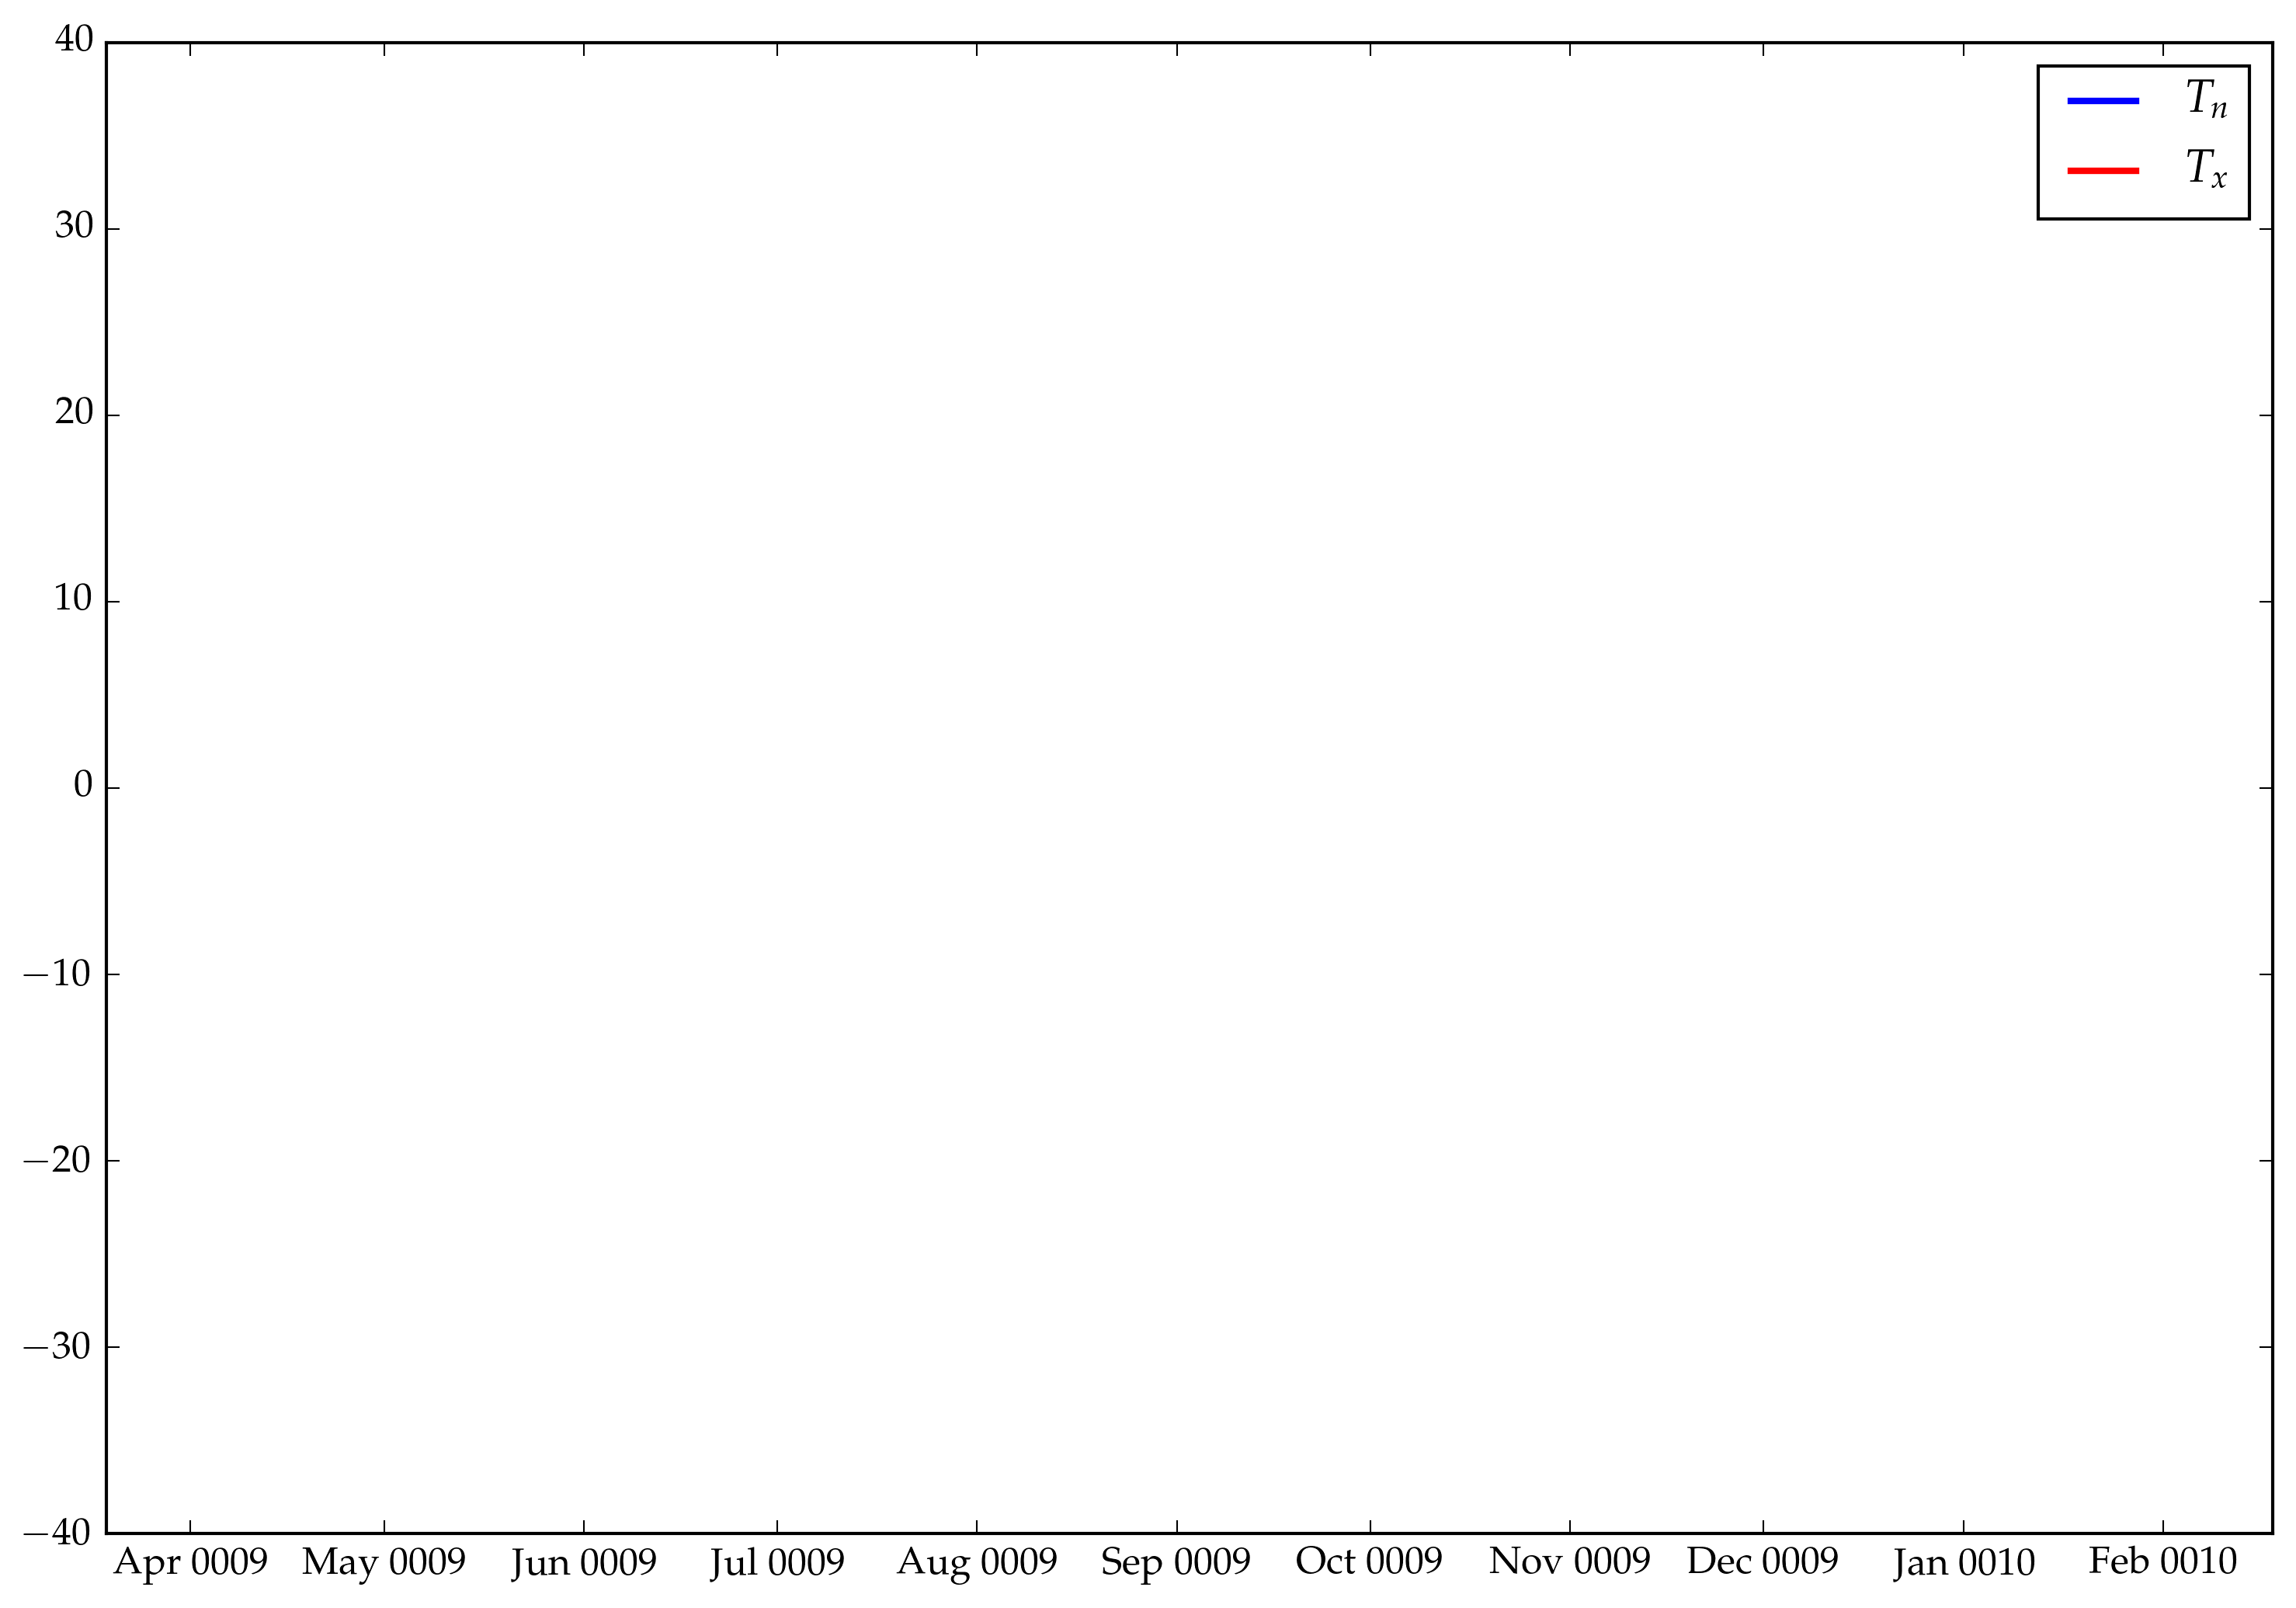

In [8]:
plt.plot(test_trimmed[:ts].values, test_trimmed[:temp].values, color="grey")
plt.plot(test_trimmed[:ts].values, test_trimmed[:Tn].values, color="blue", linewidth=2, label=L"$T_n$")
plt.plot(test_trimmed[:ts].values, test_trimmed[:Tx].values, color="red", linewidth=2, label=L"$T_x$")
plt.xlim(3000,3000+24*14)
plt.legend()
;

# Kernel Specification

In [10]:
# Temporal
k1 = FixedPeriodic(0.0,0.0,log(24.0))
k2 = RQIso(0.0,0.0,0.0)
k3 = SEIso(0.0,0.0)
k4 = RQIso(0.0,0.0,0.0)
k5 = RQIso(0.0,0.0,0.0)
k6 = SE(0.0,0.0)
k_time=k1+k2+k3+k4+k5+k6
# hyperparameters fitted in JuliaGP_timeseries_chunks.ipynb
hyp=[-1.4693,-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
set_params!(k_time, hyp[2:end])

# Spatial
k_spatial = SEIso(log(2*10^5), log(1.0))
hyp=[-1.60692,11.4161,0.280207]
set_params!(k_spatial, hyp[2:3])
logNoise=hyp[1]
;

In [11]:
print("\nTemporal\n================\n")
print("  k₁: Periodic \n-----------------\n")
@printf("     σ: %5.3f\n", √k1.σ2)
@printf("     l: %5.3f\n", √k1.ℓ2)
@printf("     p: %5.0f hours\n", k1.p)
print("\n  k₂: RQIso \n-----------------\n")
@printf("     σ: %5.3f\n", √ k2.σ2)
@printf("     l: %5.3f hours\n", √ k2.ℓ2)
@printf("     α: %5.3f\n", k2.α)
print("\n  k₃: SEIso \n-----------------\n")
@printf("     σ: %5.3f\n", √k3.σ2)
@printf("     l: %5.3f hours\n", √k3.ℓ2)
print("\n  k₄: RQIso \n-----------------\n")
@printf("     σ: %5.3f\n", √k4.σ2)
@printf("     l: %5.3f days\n", √k4.ℓ2 / 24)
@printf("     α: %5.3f\n",  k4.α)
print("\n  k₅: RQIso \n-----------------\n")
@printf("     σ: %5.3f\n", √k5.σ2)
@printf("     l: %5.3f days\n", √k5.ℓ2 / 24)
@printf("     α: %5.3f\n",  k5.α)
print("\n  k₆ SEIso \n-----------------\n")
@printf("     σ: %5.3f\n", √k6.σ2)
@printf("     l: %5.3f days\n", √k6.ℓ2 / 24)
print("\nSpatial\n================\n")
print("\n  k: SEIso \n-----------------\n")
@printf("     σ: %5.3f\n", √k_spatial.σ2)
@printf("     l: %5.3f\n", √k_spatial.ℓ2)
print("\nNoise\n================\n")
@printf("     σy: %5.3f\n", exp(logNoise))


Temporal
  k₁: Periodic 
-----------------
     σ: 2.843
     l: 0.923
     p:    24 hours

  k₂: RQIso 
-----------------
     σ: 3.028
     l: 4.517 hours
     α: 0.250

  k₃: SEIso 
-----------------
     σ: 0.349
     l: 0.293 hours

  k₄: RQIso 
-----------------
     σ: 3.623
     l: 0.922 days
     α: 17.138

  k₅: RQIso 
-----------------
     σ: 1.599
     l: 1.598 days
     α: 20.280

  k₆ SEIso 
-----------------
     σ: 0.005
     l: 92.656 days

Spatial

  k: SEIso 
-----------------
     σ: 1.323
     l: 90771.442

Noise
     σy: 0.201


In [12]:
k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3])

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
  Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [11.4161,0.280207]


# Fitting GP on training data

In [13]:
function subset(df, from, to)
    after_from = df[:ts].values .>= from
    before_to = df[:ts].values .<= to
    return df[after_from & before_to,:]
end

train_subset = subset(hourly_train,DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0))
avgtemp=by(train_subset, :station, df->DataFrame(avgtemp=mean(df[:temp].values)))
train_subset = join(train_subset, avgtemp, on=:station)

train_X_PRJ = isdSubset[:X_PRJ].values[train_subset[:station].values]
train_Y_PRJ = isdSubset[:Y_PRJ].values[train_subset[:station].values]
train_X = [train_subset[:ts_hours].values train_X_PRJ train_Y_PRJ]
train_Y = train_subset[:temp].values .- train_subset[:avgtemp].values

test_subset = subset(test_trimmed,DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0))
test_X_PRJ = isdSubset[:X_PRJ].values[test_subset[:station].values]
test_Y_PRJ = isdSubset[:Y_PRJ].values[test_subset[:station].values]
test_X = [test_subset[:ts_hours].values test_X_PRJ test_Y_PRJ]
;

In [14]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

In [15]:
prior_GP = GP(zeros(3,0), zeros(0), MeanZero(), k_spatiotemporal, logNoise);

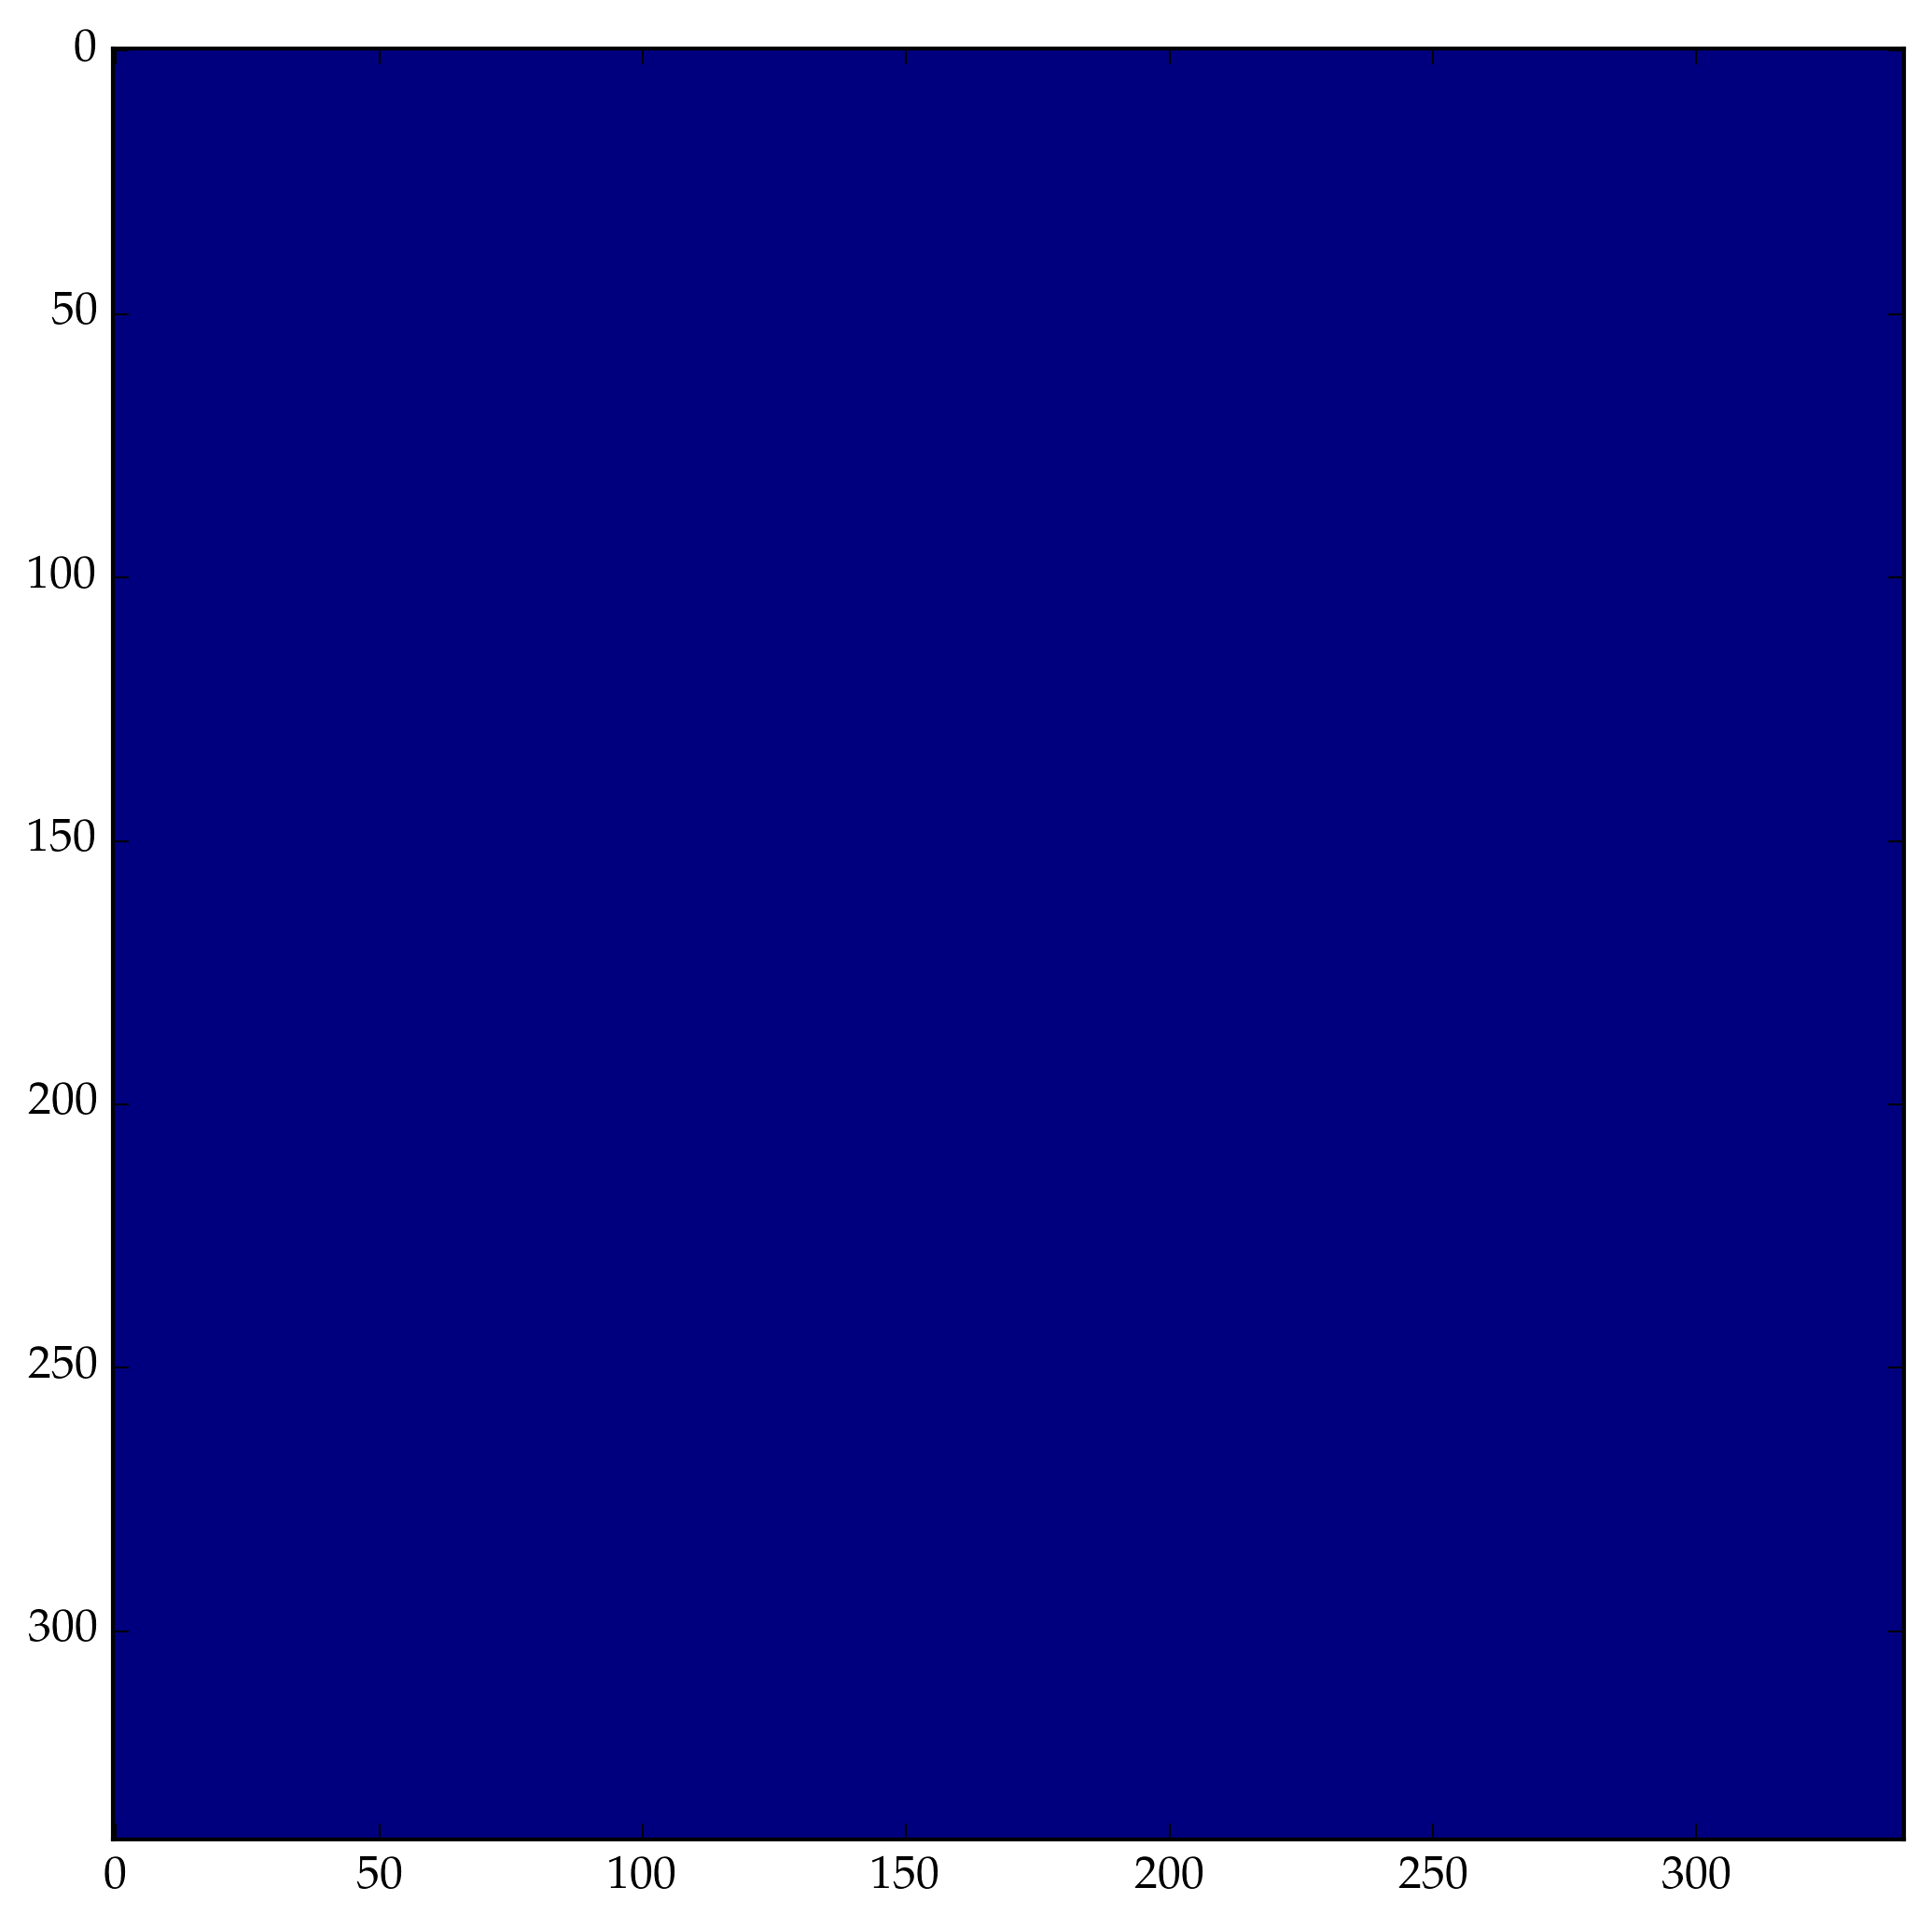

PyObject <matplotlib.image.AxesImage object at 0x31e53a3d0>

In [16]:
plt.imshow(cov(k_spatiotemporal.kerns[2], test_X'))

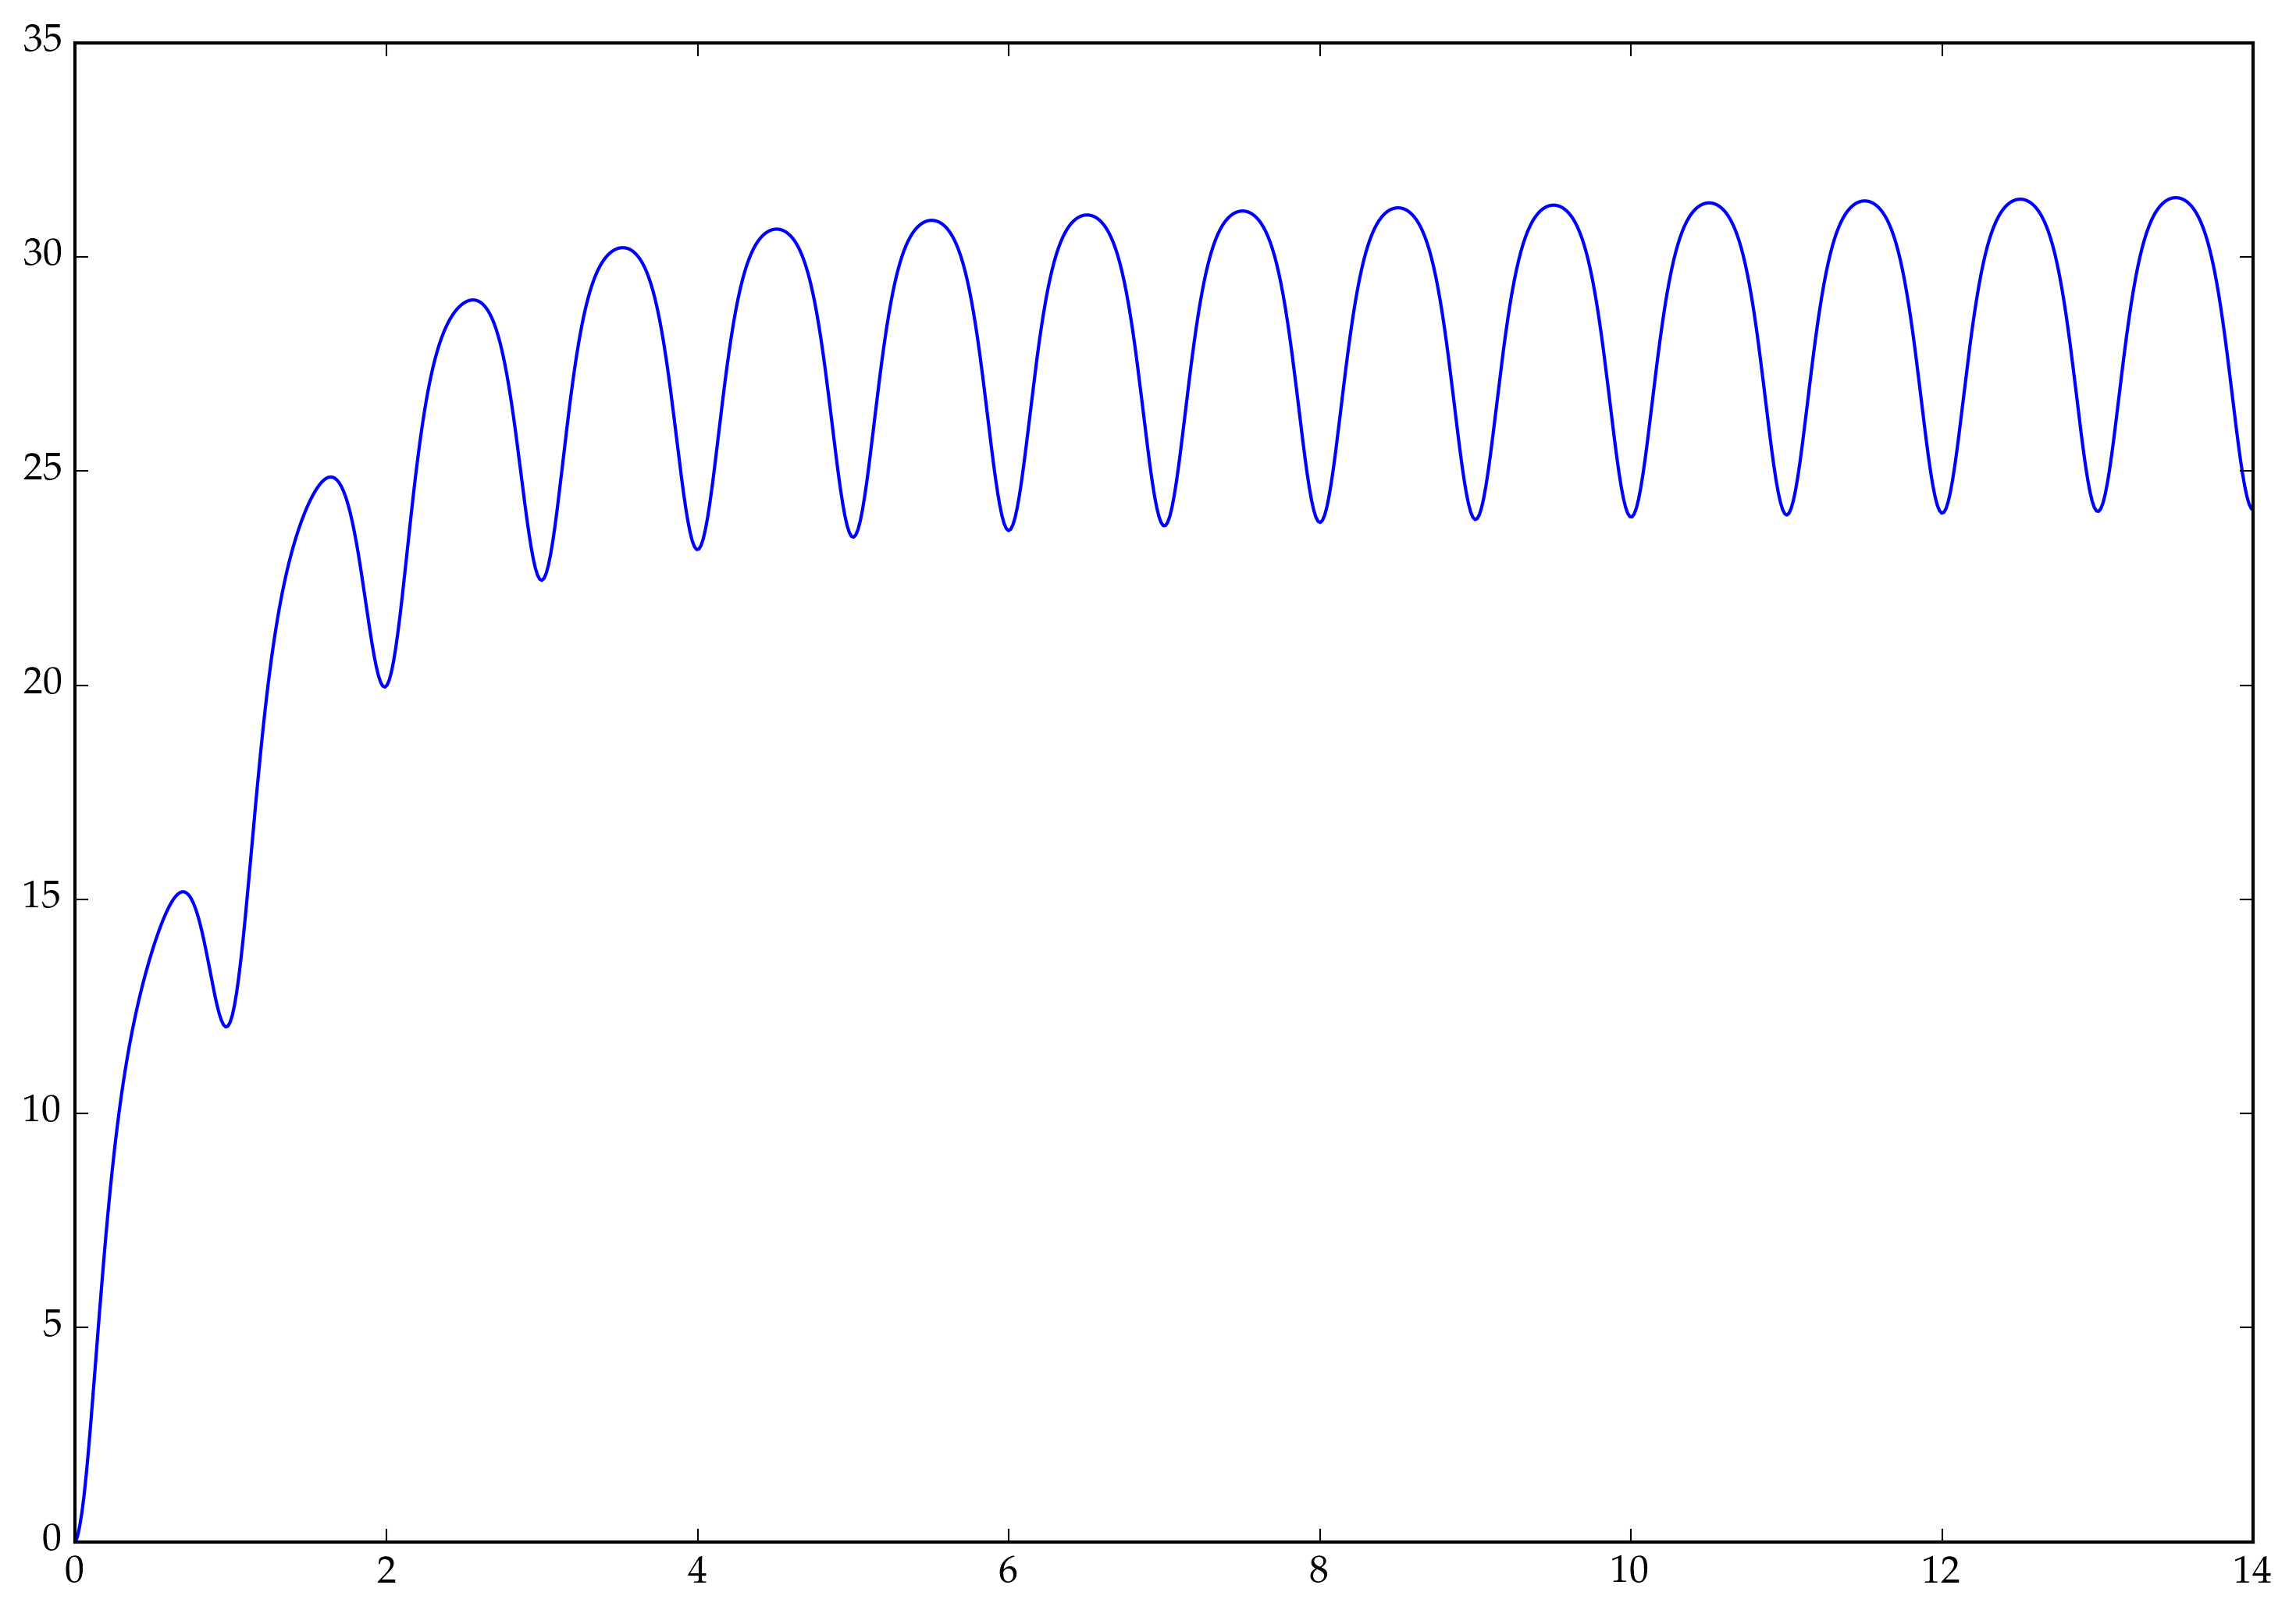

  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  li

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320a24850>

In [17]:
begin
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(k_time, r) for r in rr]
    plt.plot(rr/24, ck_r[1]-ck_r)
end

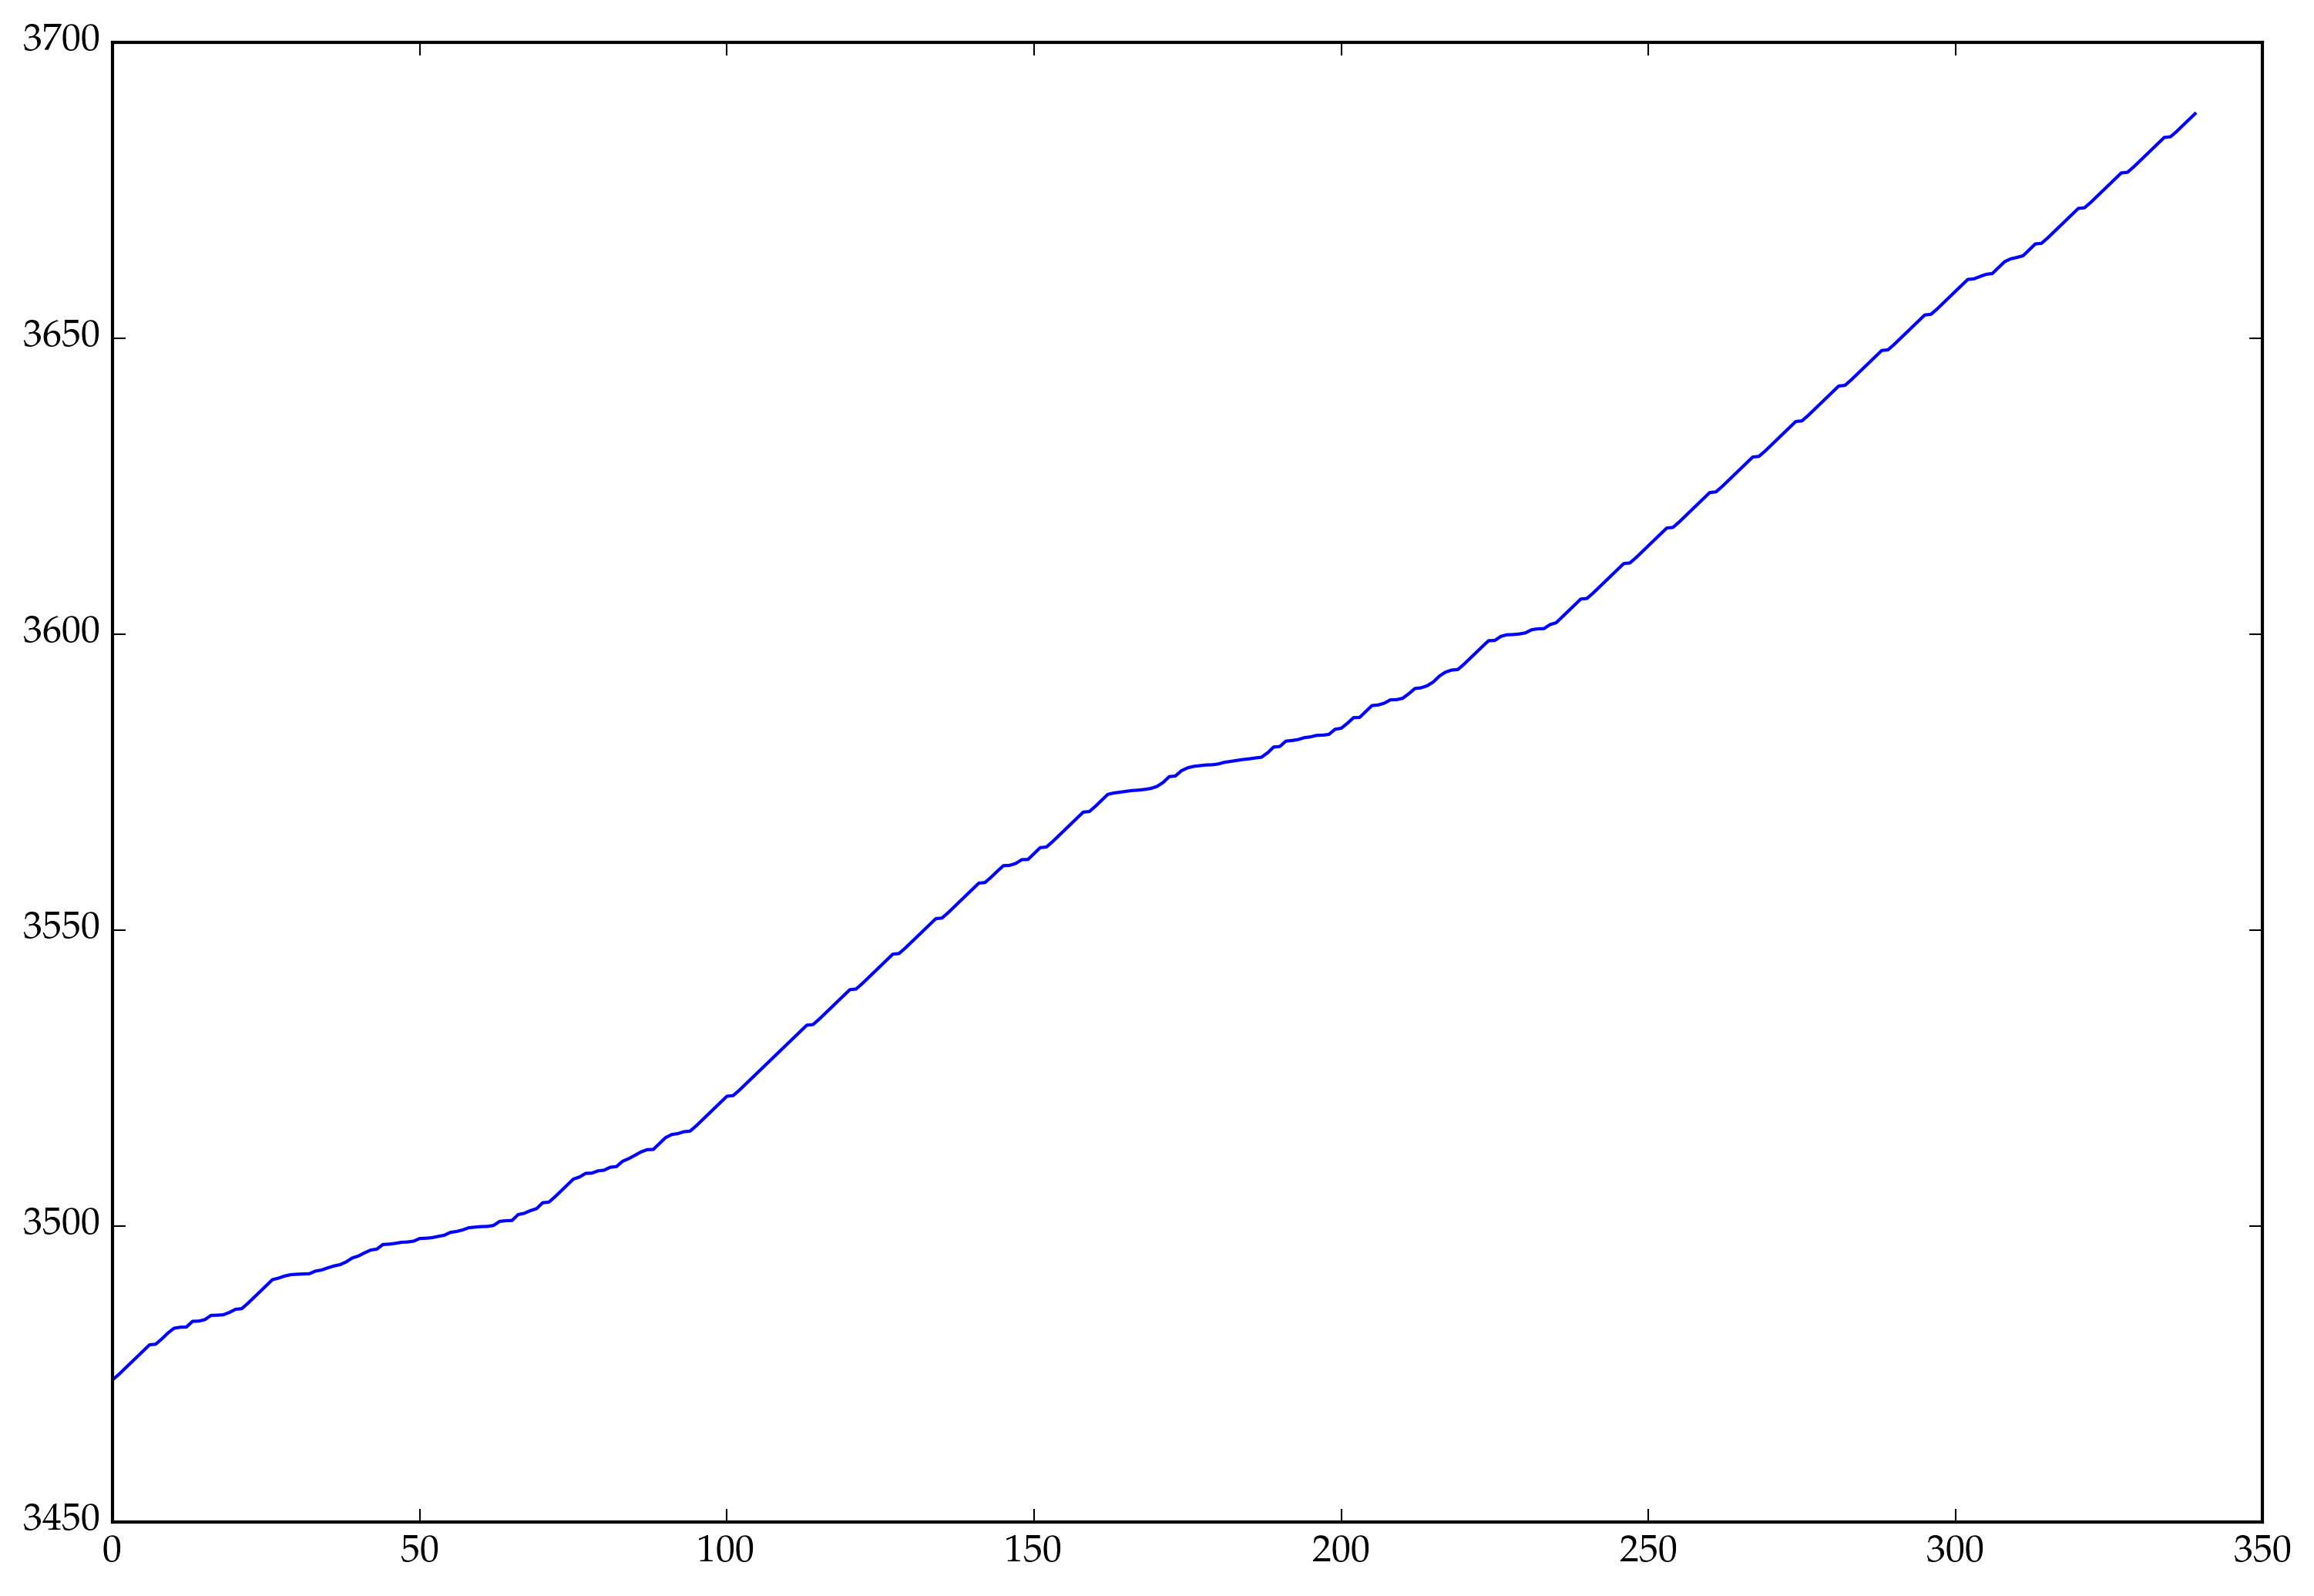

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x322397c50>

In [18]:
plt.plot(test_X[:,1])

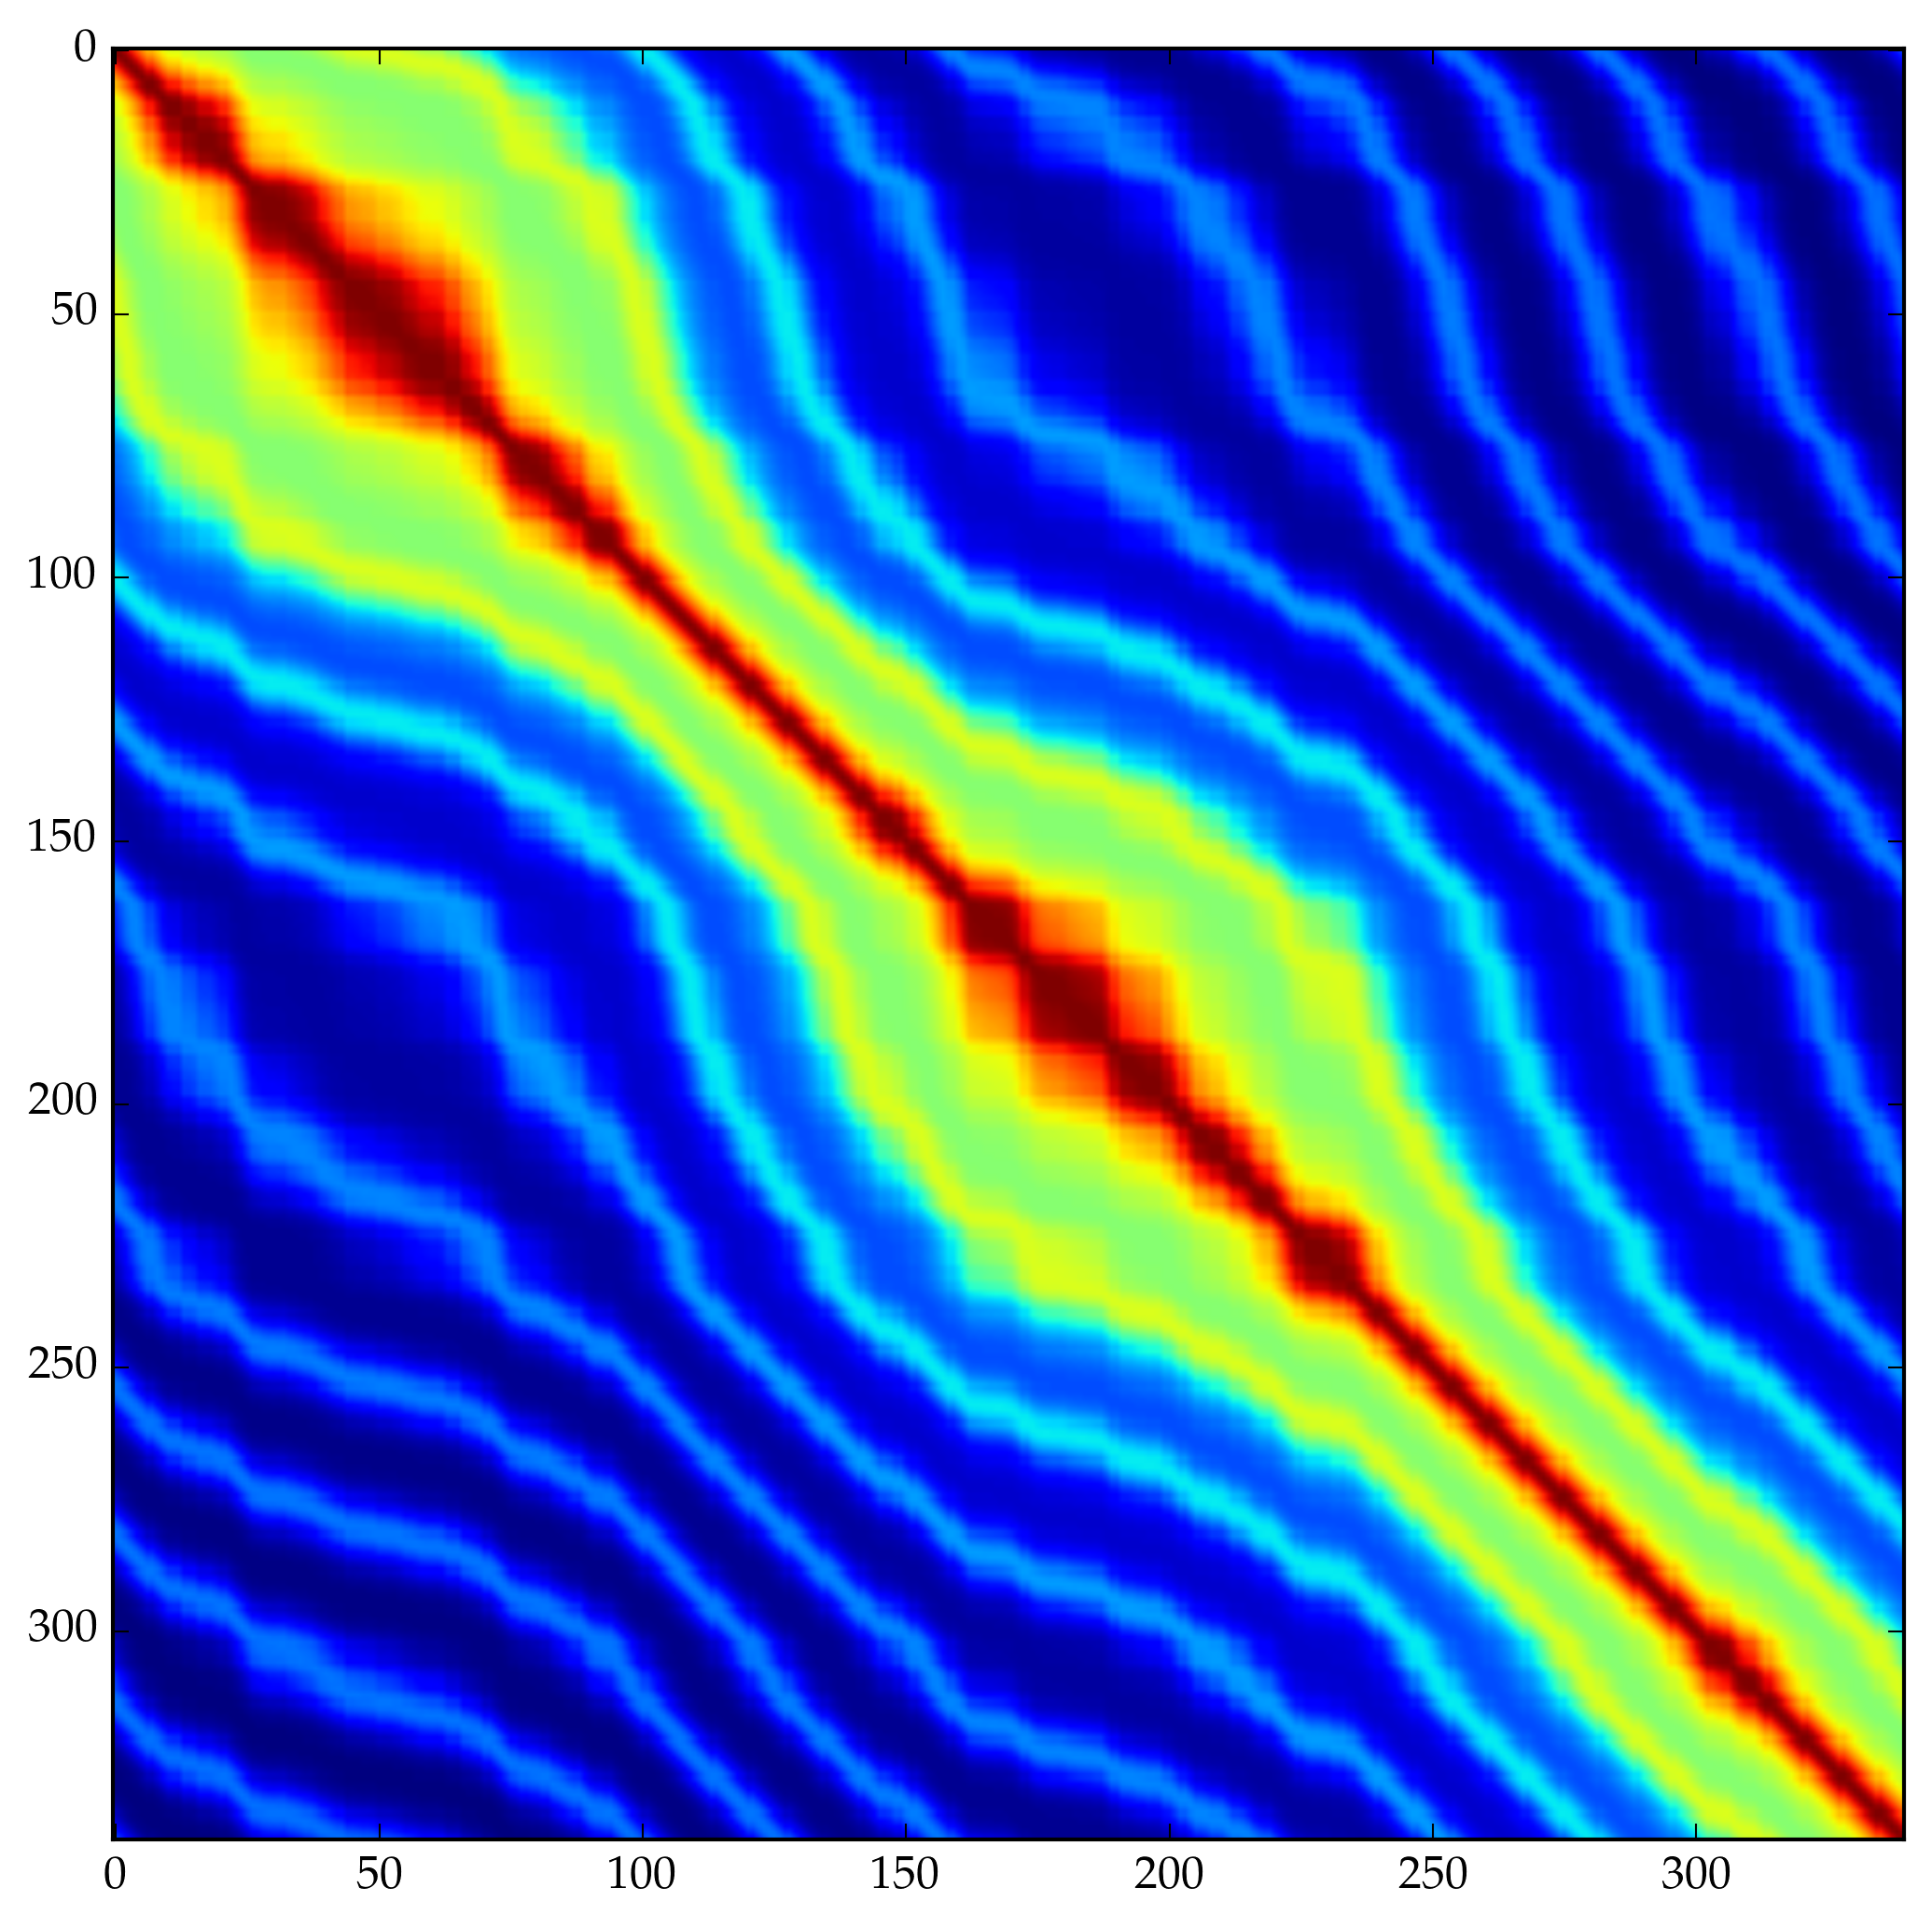

PyObject <matplotlib.image.AxesImage object at 0x322247e10>

In [19]:
plt.imshow(cov(k_spatiotemporal, test_X'))

## Predicting at the test location

In [20]:
test_prediction=predict(train_GP, test_X'; full_cov=true);
prior_prediction=predict(prior_GP, test_X'; full_cov=true);

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

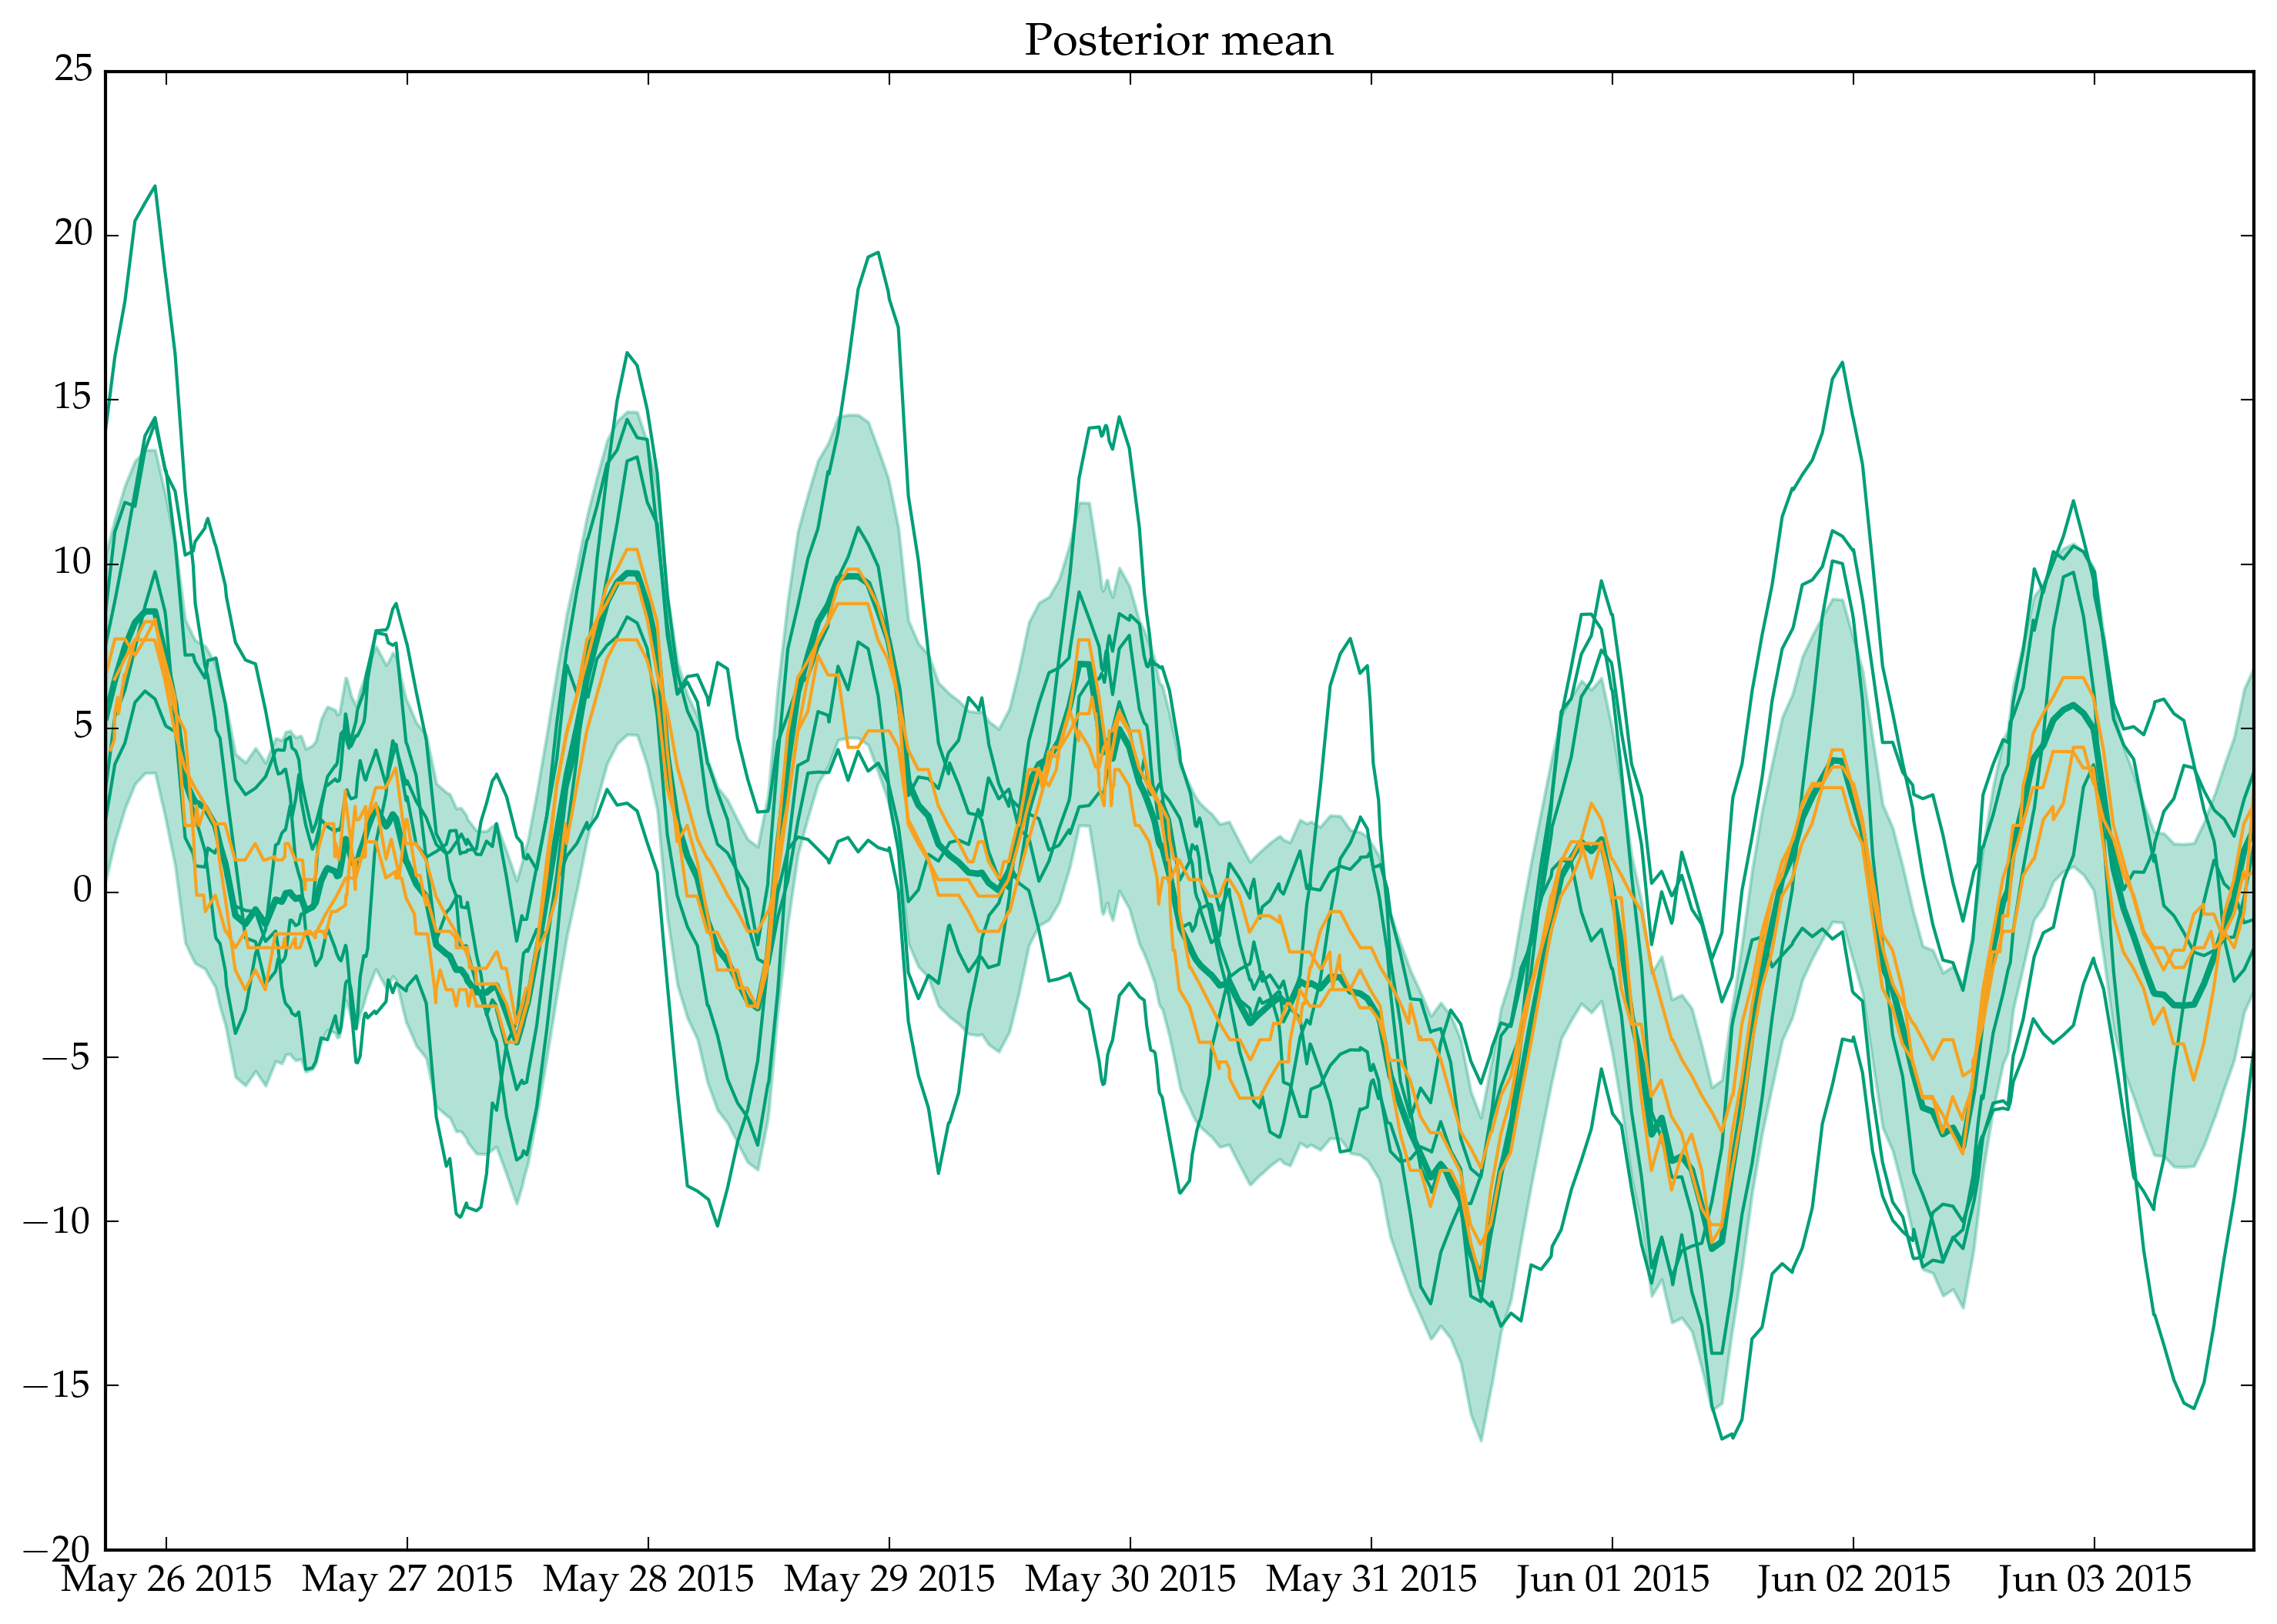

In [21]:
begin
    ts=test_subset[:ts].values
    μ = test_prediction[1]
    Σ = test_prediction[2]
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        plt.plot(ts, rand(distr), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-√diag(Σ),μ+√diag(Σ), color="#009F77", alpha=0.3)
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F")
    end

    plt.title("Posterior mean")
end
;

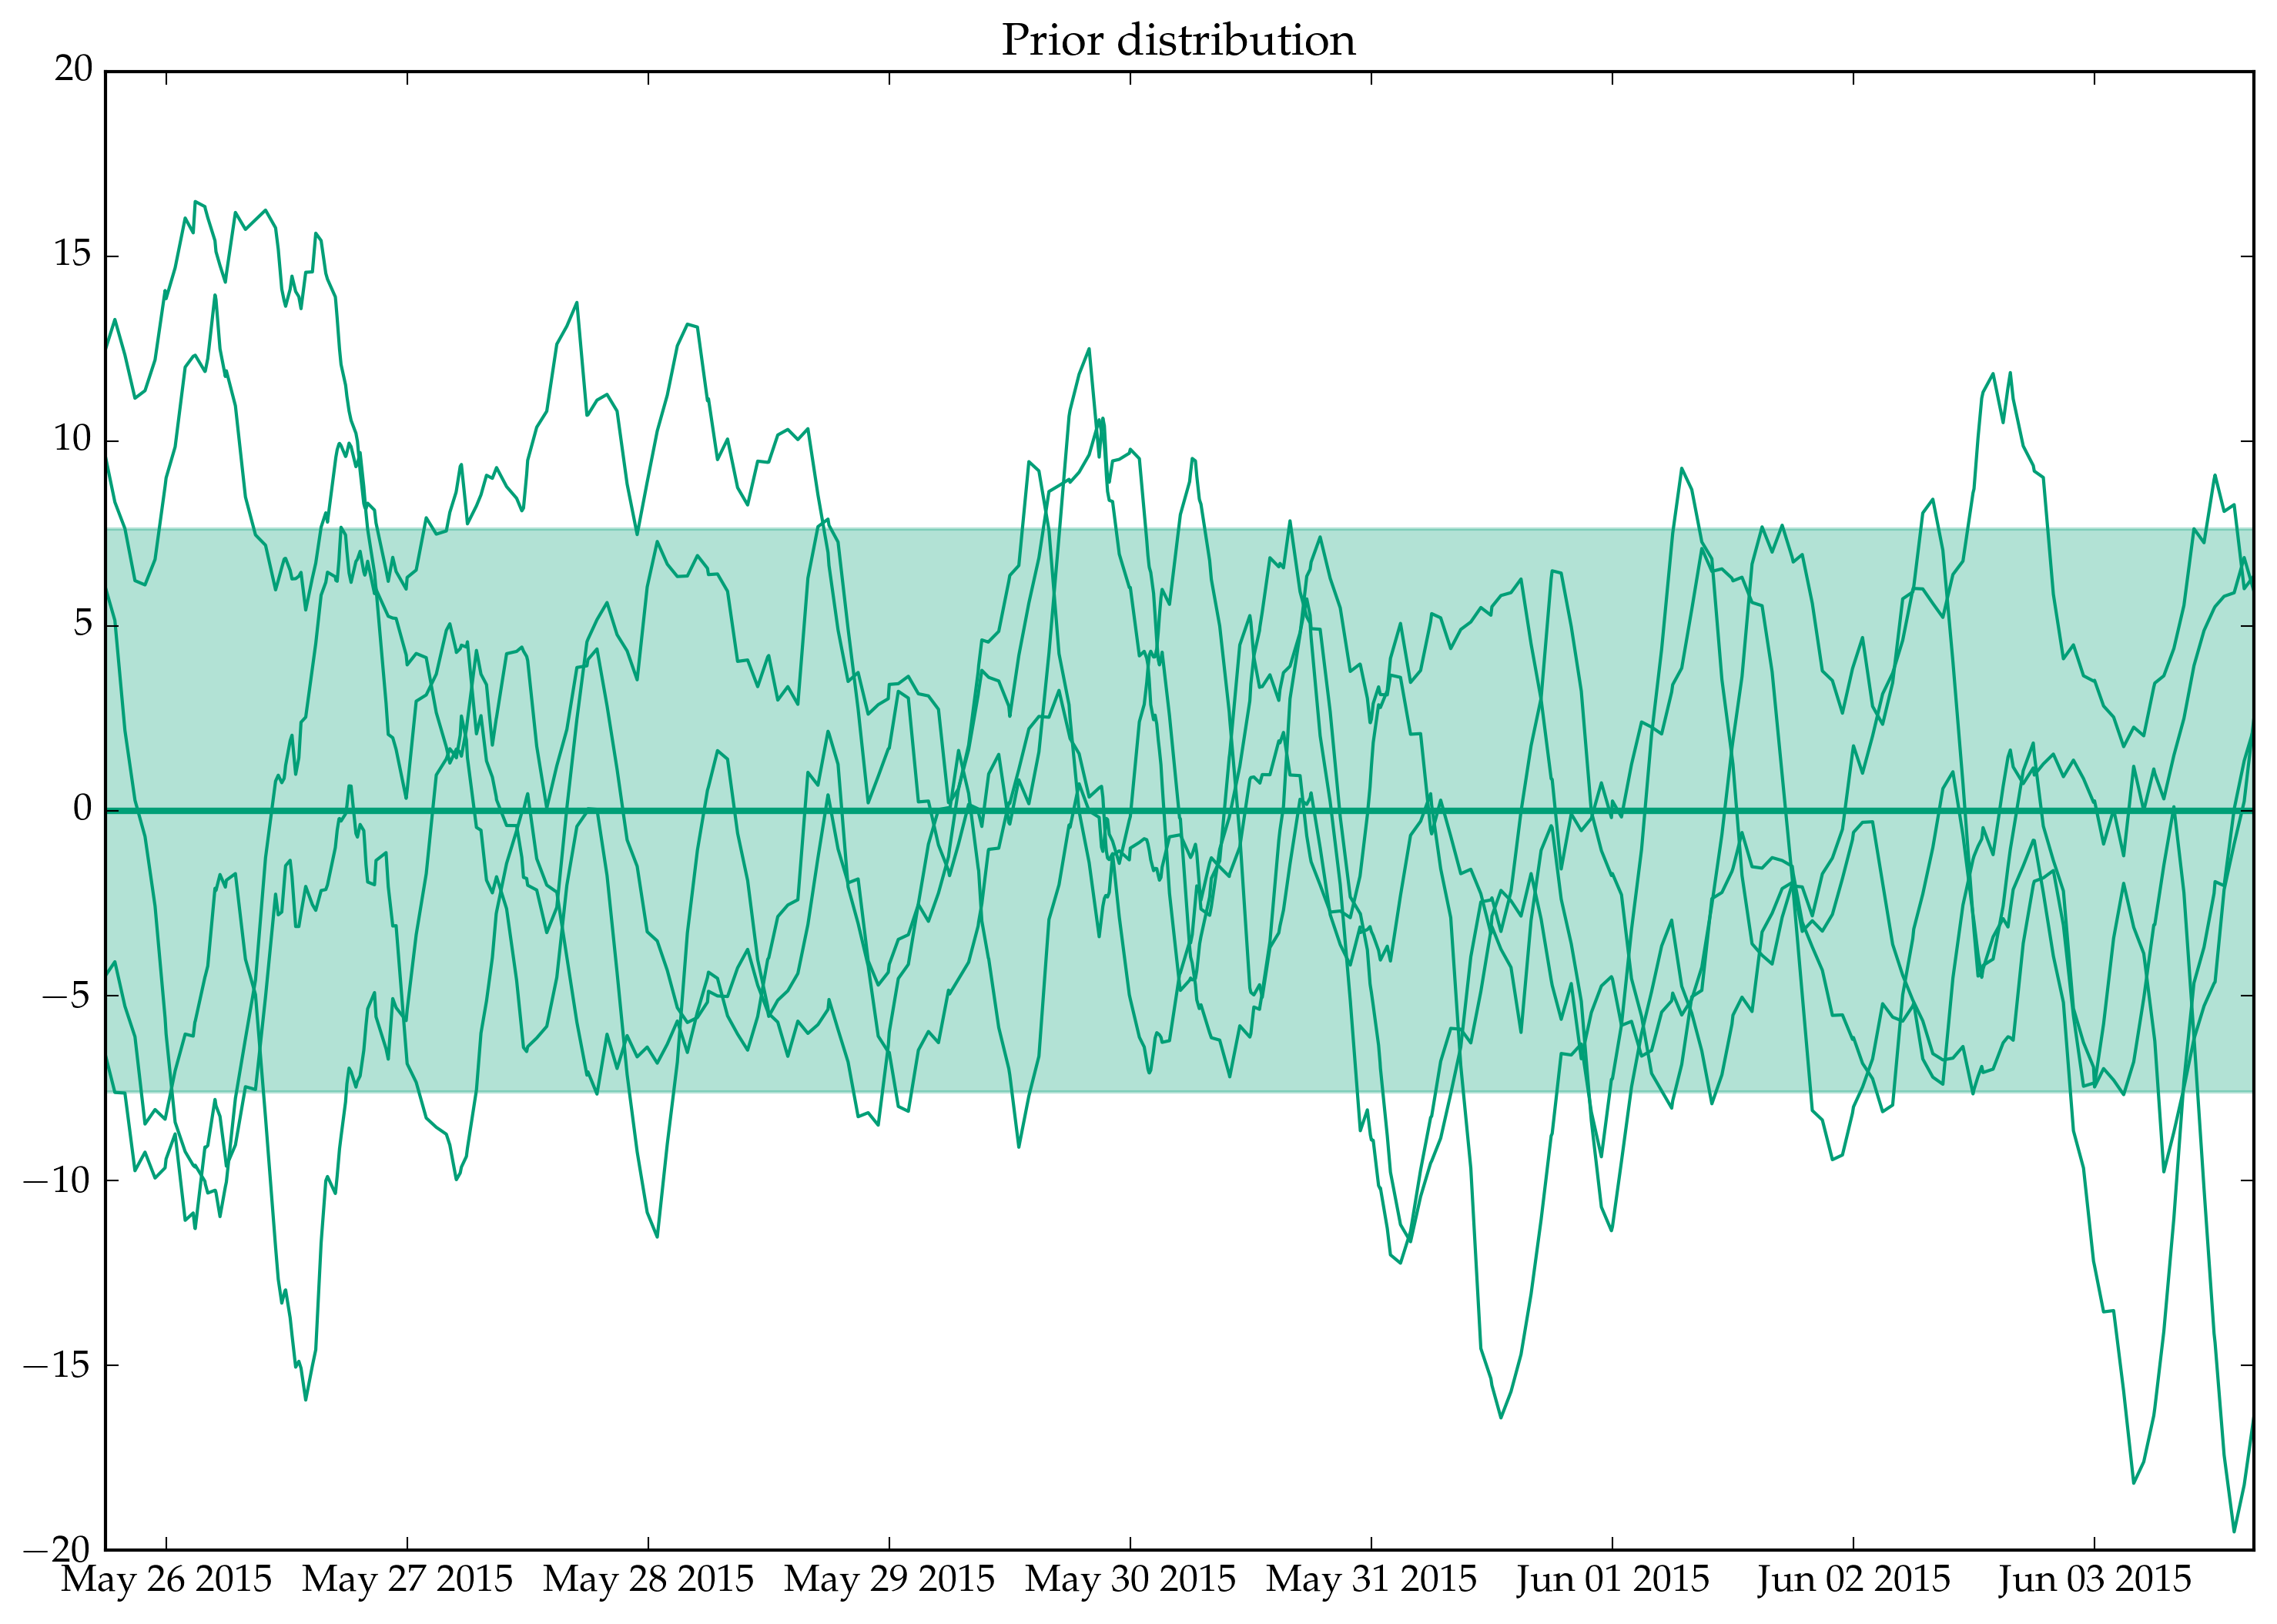

In [22]:
begin
    ts=test_subset[:ts].values
    μ = prior_prediction[1]
    Σ = prior_prediction[2]
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="prior mean")
    for _ in 1:5
        plt.plot(ts, rand(distr), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-√diag(Σ),μ+√diag(Σ), color="#009F77", alpha=0.3)

    plt.title("Prior distribution")
end
;

# Specifying STAN model

In [23]:
imputation_model = """
functions {
    real softmax(vector x, real k){
        real max10x;
        max10x = max(k*x);
        return (max10x+log(sum(exp(k*x - max10x))))/k;
    }
    real softmin(vector x, real k){
        return -softmax(-x, k);
    }
}
data {
    // Tn Tx data
    int<lower=1> N_TxTn; //
    vector[N_TxTn] Tx;
    vector[N_TxTn] Tn;
    
    // imputation points (for which we have )
    int<lower=1> Nimpt;
    int<lower=1,upper=N_TxTn> day_impute[Nimpt];
    // number of hours recorded within each day
    int<lower=1> impt_times_p_day[N_TxTn];
    
    // prior 
    vector[Nimpt] predicted_mean;
    matrix[Nimpt,Nimpt] predicted_cov;
    matrix[Nimpt,Nimpt] predicted_cov_chol;
    
    // control soft max hardness
    real<lower=0> k_softmax;
}
parameters {
    vector[Nimpt] temp_impt;
    real mu;
}
transformed parameters {
    real Tsoftmax[N_TxTn];
    real Tsoftmin[N_TxTn];  
    {
        int istart;
        istart = 1;
        for (i in 1:N_TxTn){
            int ntimes;
            ntimes = impt_times_p_day[i];
            Tsoftmin[i] = softmin(segment(temp_impt,istart,ntimes)+mu, k_softmax);
            Tsoftmax[i] = softmax(segment(temp_impt,istart,ntimes)+mu, k_softmax);
            istart = istart + ntimes;
        }
    }
}
model {
    // temp_impt ~ multi_normal(predicted_mean, predicted_cov);
    mu ~ normal(0, 100.0);
    temp_impt ~ multi_normal_cholesky(predicted_mean, predicted_cov_chol);
    Tn ~ normal(Tsoftmin, 0.1);
    Tx ~ normal(Tsoftmax, 0.1);
}
"""
stanmodel = Stanmodel(name="imputation", model=imputation_model);
display(stanmodel)


File /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.stan will be updated.

  name =                    "imputation"
  nchains =                 4
  update =                   1000
  adapt =                    1000
  thin =                     1
  monitors =                String[]
  model_file =              "imputation.stan"
  data_file =                ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  

Stan.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [24]:
test_TxTn = by(test_subset, :ts_day, df -> DataFrame(
    Tn=first(df[:Tn]), 
    Tx=first(df[:Tx]), 
    times_p_day=nrow(df),
))

9×4 DataFrames.DataFrame
│ Row │ ts_day │ Tn   │ Tx   │ times_p_day │
├─────┼────────┼──────┼──────┼─────────────┤
│ 1   │ 145    │ 15.6 │ 25.6 │ 46          │
│ 2   │ 146    │ 13.9 │ 22.8 │ 54          │
│ 3   │ 147    │ 13.9 │ 26.7 │ 27          │
│ 4   │ 148    │ 16.7 │ 27.2 │ 31          │
│ 5   │ 149    │ 12.8 │ 26.7 │ 59          │
│ 6   │ 150    │ 6.7  │ 16.1 │ 36          │
│ 7   │ 151    │ 6.7  │ 19.4 │ 28          │
│ 8   │ 152    │ 10.0 │ 21.7 │ 32          │
│ 9   │ 153    │ 15.0 │ 23.9 │ 27          │

In [25]:
ts_day = test_subset[:ts_day].values
imputation_data = Dict(
    "N_TxTn" => nrow(test_TxTn),
    "Tn" => test_TxTn[:Tn].values,
    "Tx" => test_TxTn[:Tx].values,
    "Nimpt" => nrow(test_subset),
    "day_impute" => ts_day .- minimum(ts_day) + 1,
    "impt_times_p_day" => test_TxTn[:times_p_day].values,
    "predicted_mean" => test_prediction[1],
    "predicted_cov" => test_prediction[2].mat,
    "predicted_cov_chol" => full(test_prediction[2].chol[:U]),
    "k_softmax" => 10.0,
    
)

Dict{String,Any} with 10 entries:
  "Tx"                 => [25.6,22.8,26.7,27.2,26.7,16.1,19.4,21.7,23.9]
  "predicted_cov_chol" => [4.95313 4.7905 … 0.991153 1.16659; 0.0 1.09406 … -0.…
  "impt_times_p_day"   => [46,54,27,31,59,36,28,32,27]
  "Nimpt"              => 340
  "Tn"                 => [15.6,13.9,13.9,16.7,12.8,6.7,6.7,10.0,15.0]
  "N_TxTn"             => 9
  "day_impute"         => [1,1,1,1,1,1,1,1,1,1  …  9,9,9,9,9,9,9,9,9,9]
  "predicted_cov"      => [24.5335 23.728 … 4.90931 5.77826; 23.728 24.1459 … 4…
  "predicted_mean"     => [5.34521,6.46607,7.48115,8.22502,8.55807,8.56415,7.23…
  "k_softmax"          => 10.0

# Running STAN

In [26]:
@time sim1 = stan(stanmodel, [imputation_data], CmdStanDir=Stan.CMDSTAN_HOME);



--- Translating Stan model to C++ code ---
bin/stanc /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.stan --o=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.hpp
Model name=imputation_model
Input file=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.stan
Output file=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation.hpp

--- Linking C++ model ---
g++ -I src -I stan_2.12.0/src -isystem stan_2.12.0/lib/stan_math_2.12.0/ -isystem stan_2.12.0/lib/stan_math_2.12.0/lib/eigen_3.2.9 -isystem stan_2.12.0/lib/stan_math_2.12.0/lib/boost_1.60.0 -isystem stan_2.12.0/lib/stan_math_2.12.0/lib/cvodes_2.8.2/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe  -Wno-unused-function -ftemplate-depth-256    -O3 -o /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/imputation src/cmdstan/main.cpp -include /U

In [27]:
describe(sim1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
                   Mean            SD         Naive SE         MCSE          ESS    
         lp__ -186.684016500 12.7349390554 0.201357066392 0.370236379874 1000.000000
accept_stat__    0.758096888  0.2575768156 0.004072647049 0.018874668359  186.232246
   stepsize__    0.087677700  0.0097577355 0.000154283346 0.001562292854   39.009752
  treedepth__    5.405750000  0.7669837048 0.012127077178 0.082797162948   85.810684
 n_leapfrog__   54.418750000 15.3444863633 0.242617632167 1.371239061032  125.221344
  divergent__    0.148250000  0.3553920559 0.005619241794 0.019178271292  343.397015
     energy__  357.393133000 18.4216494865 0.291271853173 0.524534550655 1000.000000
  temp_impt.1    3.258748858  2.9750697957 0.047039983762 0.168378164383  312.192723
  temp_impt.2    6.300565182  0.9128083421 0.014432767141 0.021113288268 1000.000000
  temp_impt.3    7.057294740  0.60

In [28]:
# convenience function to extract the imputed temperatures
# from the STAN model object
temp_varnames=[@sprintf("temp_impt.%d", i) for i in 1:imputation_data["Nimpt"]]

function get_temperatures(sim::Mamba.Chains)
    mu_samples=getindex(sim, :, "mu", :).value
    temp_samples=getindex(sim, :, temp_varnames, :).value
    temp_impute=broadcast(+, mu_samples, temp_samples)
end

temp_impute = get_temperatures(sim1);

# Plotting

In [29]:
stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
sorted_impute = sort(stacked_impute,1);
nsamples=size(sorted_impute,1)
# extract and 2.5th and 97.5th percentiles
# of the imputations
imputed_025 = sorted_impute[div(nsamples,40), :]
imputed_975 = sorted_impute[nsamples-div(nsamples,40), :]
;

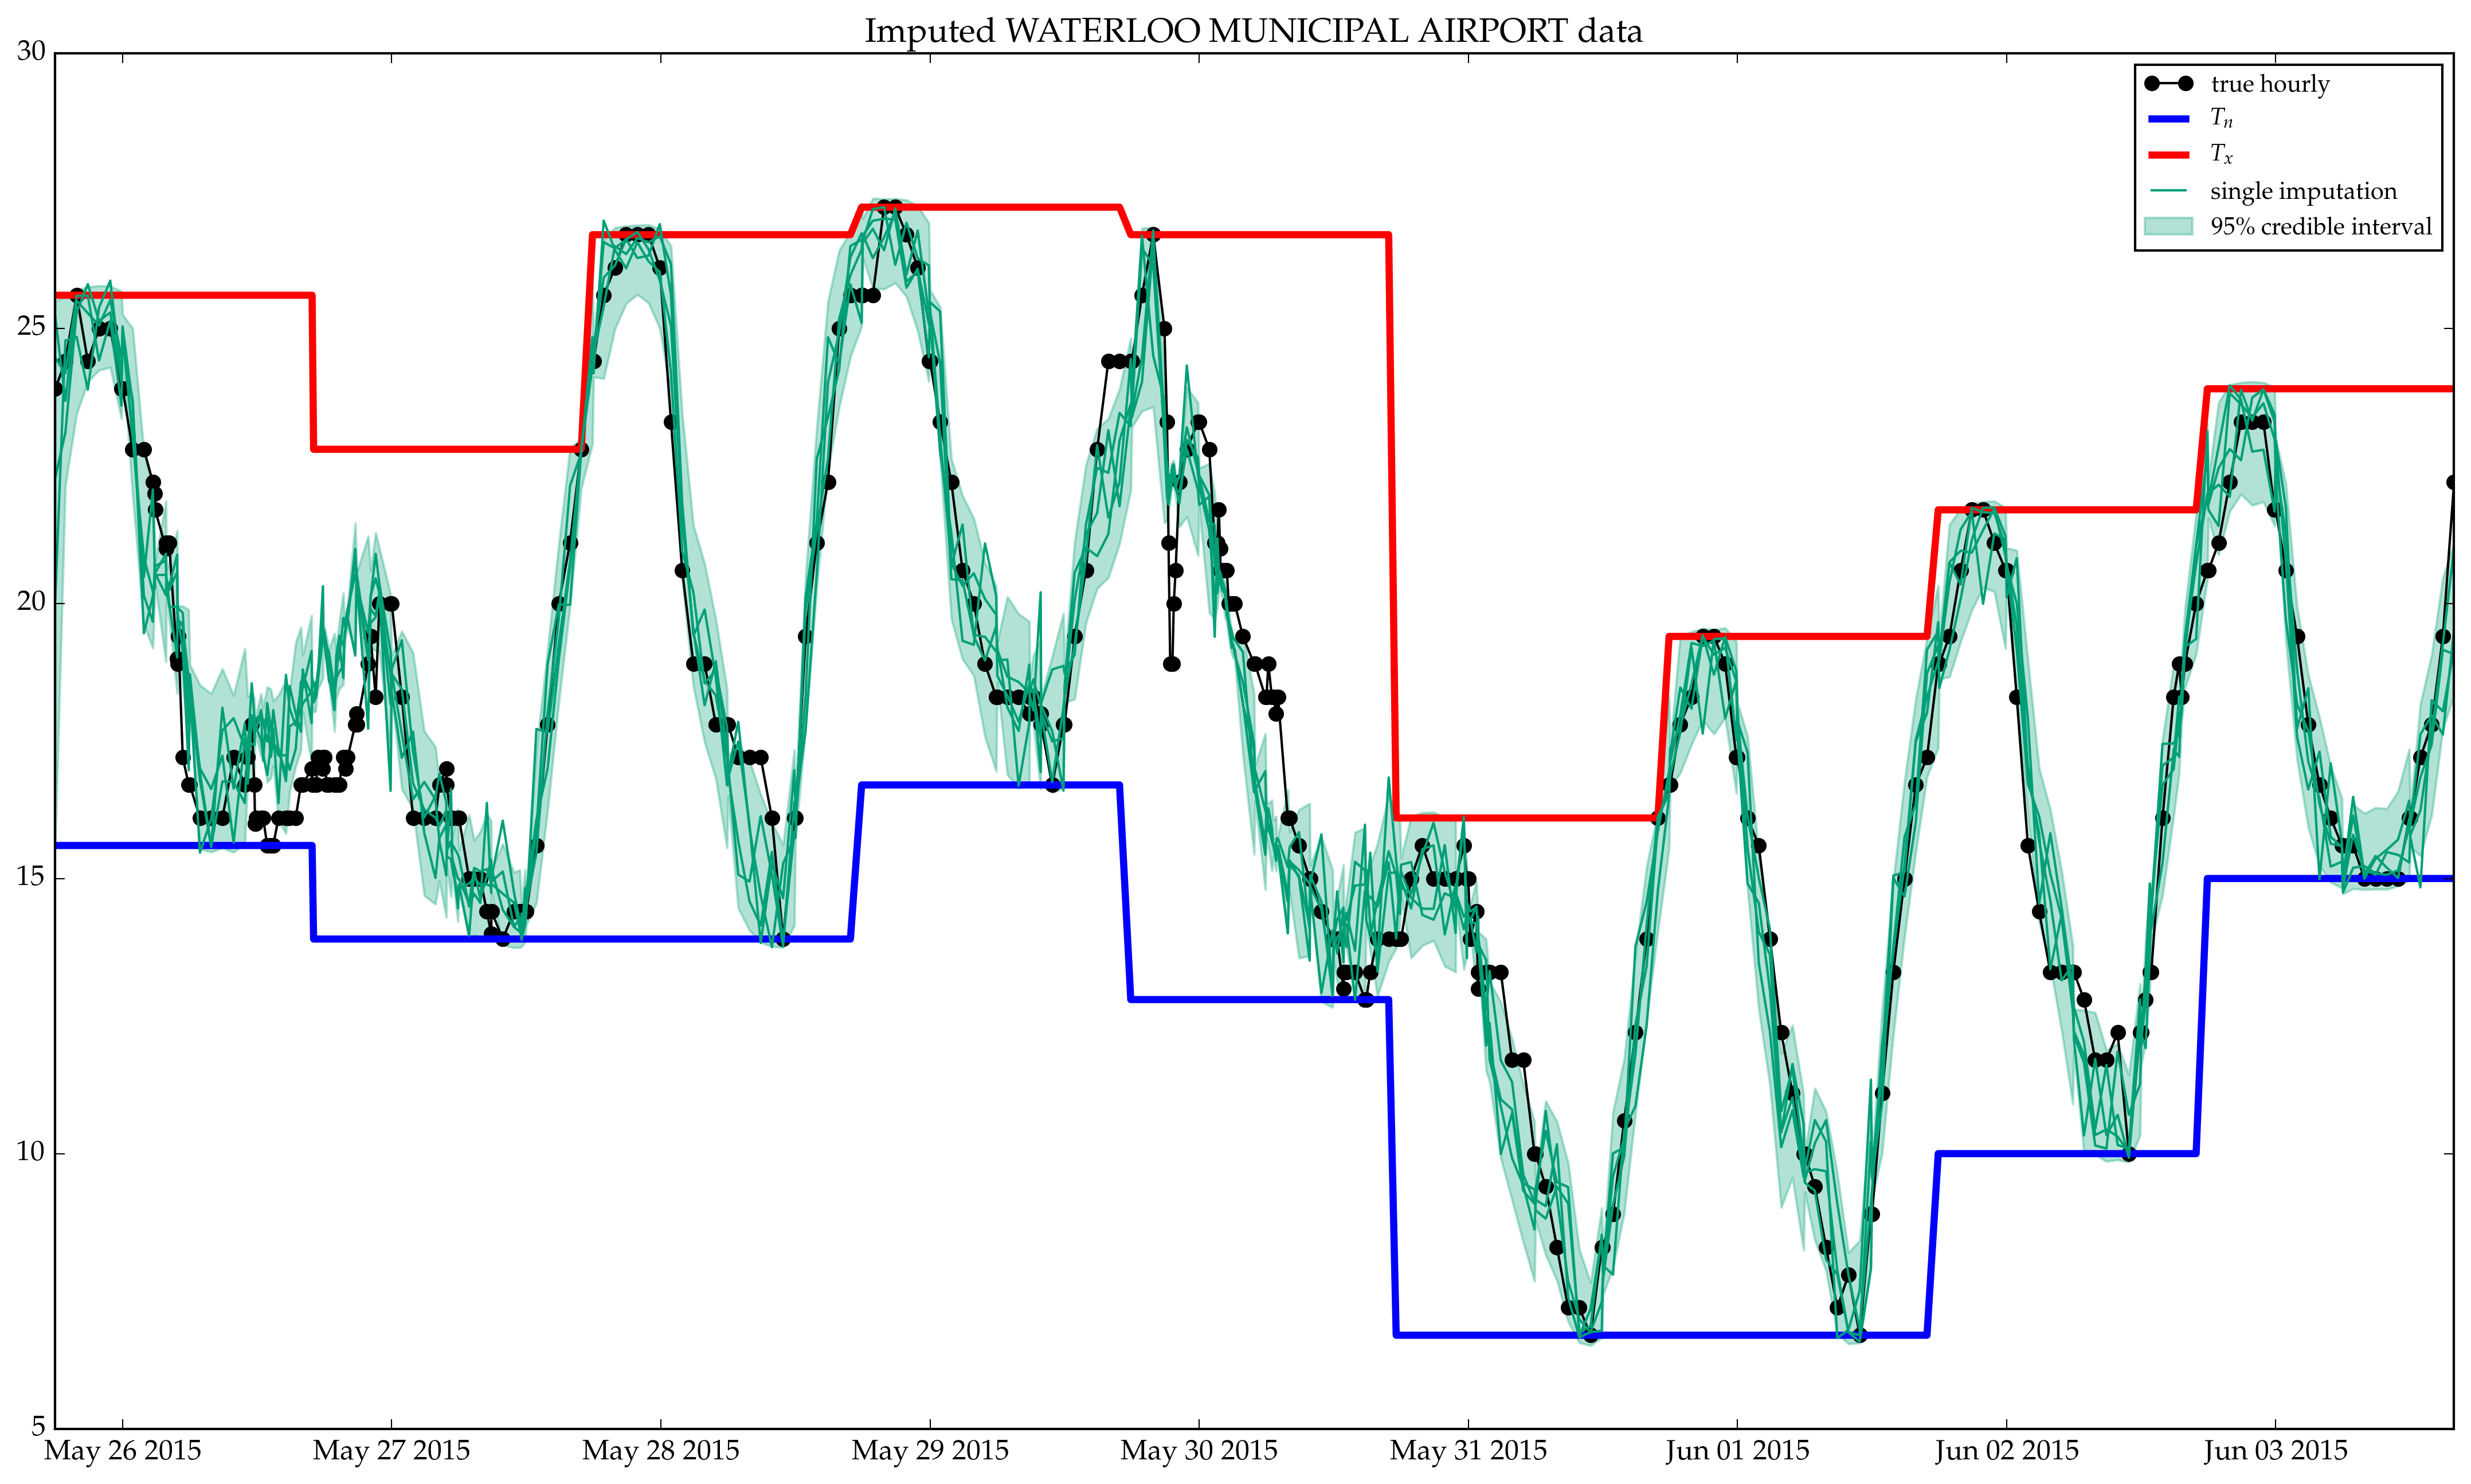

In [32]:
begin
    ts = test_subset[:ts].values
    plt.plot(ts, test_subset[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95\%$ credible interval")
    plt.plot(ts, temp_impute[800,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[800,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
end
;

# Observations

This is quite similar to the previous plot I showed that did the entire analysis in `STAN`, but now we have a more complete kernel, fitted by optimizing the marginal log-likelihood, which to me means that we have a more believable model of the temporal and spatial covariance structures. The other change is that we've now separated the imputation procedure into two separate steps, which use two separate sources of information about the temperatures:

1. the hourly temperatures at nearby stations
2. the $T_n$ and $T_x$ records at the test station

The advantage is that incorporating the nearby hourly temperatures can be done analytically once we specify a Gaussian Process model. So that step is computationally very quick. We then only use Stan (Hamiltonian Monte Carlo) to add the second source of information. The STAN model is therefore hugely simplified, and the fitting time is greatly reduced.

We're getting good convergence diagnostics from Stan, and the imputed temperatures both:
1. stay within the constraints imposed by $T_n$ and $T_x$
2. are very close to the true temperatures at Waterloo Municipal Airport
3. on May 27th and 28th the model accurately finds that the high for both days is set in the same afternoon, and that the peak of the previous diurnal cycle does not get recorded

Sources of worry are:
* the imputed temperatures are too noisy, the true temperatures are smoother, like in the draws from the predictive distribution we saw coming out of the $\GP$
* the 95% credible envelope also isn't very smooth
* the true temperatures sometimes drift out of the 95% envelope, though not necessarily more often than they should

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-import-and-preprocessing" data-toc-modified-id="Data-import-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and preprocessing</a></div><div class="lev1 toc-item"><a href="#Preparing-Test-Data" data-toc-modified-id="Preparing-Test-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Test Data</a></div><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Fitting-GP-on-training-data" data-toc-modified-id="Fitting-GP-on-training-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting GP on training data</a></div><div class="lev2 toc-item"><a href="#Predicting-at-the-test-location" data-toc-modified-id="Predicting-at-the-test-location-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predicting at the test location</a></div><div class="lev1 toc-item"><a href="#Specifying-STAN-model" data-toc-modified-id="Specifying-STAN-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Specifying STAN model</a></div><div class="lev1 toc-item"><a href="#Running-STAN" data-toc-modified-id="Running-STAN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Running STAN</a></div><div class="lev1 toc-item"><a href="#Plotting" data-toc-modified-id="Plotting-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting</a></div>